In [1]:
# import os
import SunStatistics as SS
from scipy.stats import pearsonr
%matplotlib notebook
# import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import pytz

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

G_Drive = 'G:\\My Drive\\'
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Output_Path = G_Drive+'FishIsland_Outputs/'



# Model Functions

In [2]:
def Model_Test_RF(X,y,AllData,K=10,Task = 'Predict',min_samples_split=None,Verbose=True,random_state=1):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Imp = []    
    Pred = []
    rnd=1
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).ravel()#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).ravel()#.reshape(-1, 1)
        Mod = RandomForestRegressor(min_samples_split=min_samples_split, random_state=random_state+rnd)#,bootstrap=False)
        rnd+=1
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        Pred.append(Mod.predict(AllData[X]))
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Imp.append(Mod.feature_importances_)
    Imp = np.mean(np.array(Imp),axis=0)
    Pred = np.mean(np.array(Pred),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('Imp',np.round(Imp,3)*100)
    if Task == 'Predict':
        return(Pred)
    if Task == 'Predict_Return':
        return(Pred,Imp,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)

def Model_Test_OLS(X,y,AllData,K=10,Task = 'Predict',fit_intercept=None,Scale=False,Verbose=True,random_state=1):
    if Scale==True:
        Mod = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=fit_intercept))
    else:
        Mod = make_pipeline(LinearRegression(fit_intercept=fit_intercept))
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        if y == ['VPD'] or y == ['PPFD_Avg']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(Mod.predict(AllData[X]))
        Int.append(Mod[-1].intercept_)
        Coef.append(Mod[-1].coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Pred = np.mean(np.array(Pred),axis=0)#.mean(axis=0)
    Int = np.mean(np.array(Int))
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
    if Task == 'Predict':
        return(Pred)#.values)
    if Task == 'Predict_Return':
        return(Pred,Coef,Int,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)
    
def Model_Test(X,y,AllData,K=10,Task = 'Predict',Test = 'OLS',min_samples_split=None,fit_intercept=True,Scale=False,Verbose=True,random_state=1):
    if Test == 'OLS':
        return(Model_Test_OLS(X,y,AllData,K=10,Task = Task,fit_intercept=fit_intercept,Scale=Scale,Verbose=Verbose,random_state=random_state))
    elif Test == 'RF':
        return(Model_Test_RF(X,y,AllData,K=10,Task = Task,min_samples_split=min_samples_split,Verbose=Verbose,random_state=random_state))
    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


In [3]:

def get_uv(Dir,U_bar,dec=0):
    M_dir = 270-(Dir+dec)
    U = np.cos(M_dir/180*np.pi)*U_bar
    V = np.sin(M_dir/180*np.pi)*U_bar
    return(U,V)
def get_wDir(u,v,m_dec=0):
    W_dir = np.arctan2(v,u)*180/np.pi
    W_dir = 270 - W_dir    
    W_dir[W_dir>360]-=360
    return(W_dir)

# Data

In [4]:
Taglu_Data = Output_Path+'Taglu_Data/Hourly.csv'
AWS = pd.read_csv(Taglu_Data,
parse_dates={'datetime':['Year','Month','Day','Time']}, 
).set_index('datetime')

# Gap Fill
C=['Air Temp','Net Radiation','Net SW Radiation','Net LW Radiation ','Wind Speed']
s = AWS.index.to_series()
print('Missing')
for c in C:
    print(c,AWS.loc[((AWS.index.month>=4)&(AWS.index.month<=10)),c].isnull().sum())
    miss = AWS[c].isna()
    #create consecutive groups
    g = miss.ne(miss.shift()).cumsum()
    #aggregate minimal 
    m1 = s.groupby(g).min()
    #get minimal of next groups, last value is replaced last value of index
    m2 = m1.shift(-1).fillna(AWS.index[-1])
    #get difference, convert to minutes
    out = m2.sub(m1).dt.total_seconds().div(3600).astype(int)
    AWS['Temp_Gap'] = g.map(out)
    AWS['Temp']=AWS[c].interpolate()
    AWS.loc[AWS['Temp_Gap']<=4,c]=AWS.loc[AWS['Temp_Gap']<=4,'Temp']
    AWS['Temp1']=AWS[c].shift(24)
    AWS['Temp2']=AWS[c].shift(-24)
    AWS.loc[AWS['Temp_Gap']>=4,c].fillna(AWS.loc[AWS['Temp_Gap']>=4,['Temp1','Temp2']].mean(axis=1))
AWS = AWS.drop(columns=['Temp_Gap','Temp','Temp1','Temp2'])
AWS_Rename = {'Air Temp':'Air_Temp',
              'Rainfall':'Rainfall',
              'Wind Speed':'Wind_Speed',
              'Wind direction':'Wind_Direction',
              'Net SW Radiation':'Net_SW',
              'Net LW Radiation ':'Net_LW',
              'Net Radiation':'Net_RN'}
AWS = AWS.rename(columns=AWS_Rename)
AWS_cols = list(AWS_Rename.values())

LAT = 69.371182
LON = -134.880935
TZ = -6

Temp = AWS[['Net_SW']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24+Temp.index.minute/60/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()

Temp['Daytime_Mask']=0.0
Temp.loc[Temp['Sun_Angle']>-0.5,'Daytime_Mask']=1.0

print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])
Temp = Temp.resample('H').mean()
print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])

try:
    AWS = AWS.drop(columns=['Sun_Angle','Daytime_Mask'])
except:
    pass
AWS = AWS.join(Temp[['Sun_Angle','Daytime_Mask']])

AWS['Daytime']=0
AWS.loc[AWS['Sun_Angle']>-0.5,'Daytime']=1


Mt = pytz.timezone('Canada/Mountain')
UTC = AWS.index+timedelta(hours=6)
AWS = AWS.set_index(UTC)
AWS.index = AWS.index.tz_localize(pytz.utc).tz_convert(Mt)

U,V = get_uv(AWS['Wind_Direction'],AWS['Wind_Speed'])
AWS['U_bar_AWS'] = U
AWS['V_bar_AWS'] = V
## 
print('Bad SW Fix',AWS.loc[AWS['Net_SW']<-5,'Net_SW'].count())
AWS.loc[AWS['Net_SW']<-5,'Net_SW']=-5
AWS.loc[AWS['Net_SW']<=-5,'Net_RN']=AWS.loc[AWS['Net_SW']<=-5,['Net_SW','Net_LW']].sum(axis=1)

AWS.groupby('Daytime').count()['Air_Temp']

Missing
Air Temp 40
Net Radiation 40
Net SW Radiation 40
Net LW Radiation  40
Wind Speed 40


C:\Users\User\FishIsland_Flux_Analysis\FluxProcessing\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


Daytime_Mask
0.0     99673
1.0    109924
Name: Sun_Angle, dtype: int64
Daytime_Mask
0.0    48317
0.5     3039
1.0    53443
Name: Sun_Angle, dtype: int64
Bad SW Fix 913


Daytime
0    49891
1    54870
Name: Air_Temp, dtype: int64

# EC Data

In [5]:
EC_Data = pd.read_csv(Output_Path+'FI_Footprints_2022-02-23_2000mx2m.csv',delimiter = ',',header = 0,na_values = -9999,
                   index_col=['datetime'],
                  ).drop('Unnamed: 0',axis=1)
EC_Data = EC_Data.set_index(pd.to_datetime(EC_Data.index, utc=True)).tz_convert(Mt)
EC_Data = EC_Data.rename(columns={'Daytime':'Daytime_Raw',
                                 'Sun_Angle':'Sun_Angle_Raw'})

EC_Data.loc[EC_Data['flowrate_mean']<0.0001,['VPD','Tdew']] = np.nan

U,V=get_uv(EC_Data['wind_dir'],EC_Data['wind_speed'],dec=-22)
EC_Data['U_bar_EC']=U
EC_Data['V_bar_EC']=V

FSO = pd.read_csv(Output_Path+'Skeeter_et_al_2022_Day_Fix.csv',index_col=['datetime']).drop('Unnamed: 0',axis=1)#.drop('datetime.1',axis=1)

FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSO = FSO.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
EC_Data = EC_Data.join(FSO[['NEE_FSO',
'NME_FSO']])

kwargs = {'closed':'right','label':'left'}
EC_Data_r=EC_Data.resample('h',**kwargs).mean()
EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']

EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)

EC_Data_r_mask = EC_Data.resample('h',**kwargs).count()[['fco2','fch4']]

EC_Data_r_mask.loc[EC_Data_r_mask['fco2']<2,'fco2']=np.nan
EC_Data_r_mask.loc[EC_Data_r_mask['fch4']<2,'fch4']=np.nan

EC_Data_r_mask/=2
EC_Data_r['fco2']*=EC_Data_r_mask['fco2']
EC_Data_r['fch4']*=EC_Data_r_mask['fch4']

print(EC_Data_r[['fco2','co2_flux','fch4','ch4_flux']].count())

Data_M1 = EC_Data_r[
                    ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim','air_temperature',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']
                    ].join(AWS,how='outer')
Data_M1.head()




for v in ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VPD','Tdew',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','ch4_flux','co2_flux','LE','flowrate_mean']:
    print(v)
    print((EC_Data[v].count()/EC_Data.shape[0]).round(2))
    print()

print((EC_Data_r[['fco2','co2_flux','fch4','ch4_flux']].count()/EC_Data_r.shape[0]).round(2))

print(Data_M1['fco2'].groupby(Data_M1['Daytime_Mask']).count())

# print(Data_M1[['air_temperature','AirTC_Avg']].corr())

# print(EC_Data['flowrate_mean'].describe())

fco2        1164
co2_flux    1337
fch4         653
ch4_flux     788
dtype: int64
Temp_15_1
1.0

Temp_15_2
1.0

Temp_5_1
1.0

Temp_5_2
1.0

Table_1
0.99

VPD
0.81

Tdew
0.81

AirTC_Avg
1.0

PPFD_Avg
1.0

NR_Wm2_Avg
1.0

Rain_mm_Tot
1.0

Active_Layer_1
0.99

wind_speed
0.99

u*
0.98

ch4_flux
0.36

co2_flux
0.63

LE
0.6

flowrate_mean
0.99

fco2        0.59
co2_flux    0.67
fch4        0.33
ch4_flux    0.40
dtype: float64
Daytime_Mask
0.0     103
0.5      17
1.0    1044
Name: fco2, dtype: int64


In [6]:
# plt.figure()
# plt.hist(EC_Data['flowrate_mean'])

# Merge

- Eddypro outputs have left labels (half hour timestamp corresponds to end of interval)
    * https://www.licor.com/documents/1ium2zmwm6hl36yz9bu4
- Need to close the right interval to match with AWS

In [7]:
for v1,v2 in zip(['Rain_mm_Tot','AirTC_Avg','wind_speed','NR_Wm2_Avg'],
                 ['Rainfall','Air_Temp','Wind_Speed','Net_RN']):
    DNA=Data_M1.loc[Data_M1['Active_Layer_1'].isnull()==False,[v1,v2]].dropna()
    print(v1,' ',v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(3)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Rain_mm_Tot   Rainfall
r2:  0.988
RMSE:  0.05
MBE:  -0.01

AirTC_Avg   Air_Temp
r2:  0.988
RMSE:  0.547
MBE:  -0.09

wind_speed   Wind_Speed
r2:  0.945
RMSE:  0.43
MBE:  0.0

NR_Wm2_Avg   Net_RN
r2:  0.978
RMSE:  43.069
MBE:  9.45



# ECMWF

- ECMWF data does not account for DST
    - Must offset by one hour so summer times match

In [8]:
ECMWF = pd.read_csv(G_Drive+'earthengine//Climate_Weighted_Mean_long.csv',
                    parse_dates=['system:index'],na_values=-9999,index_col=['system:index'])

UTC = ECMWF.index+timedelta(hours=-1)
ECMWF = ECMWF.set_index(UTC)
ECMWF.index = ECMWF.index.tz_localize(pytz.utc).tz_convert(Mt)
ECMWF = ECMWF.drop(columns=['.geo'])

ECMWF['Wind_10m']  =(ECMWF['u_component_of_wind_10m']**2+ECMWF['v_component_of_wind_10m']**2)**.5
ECMWF['HH']=ECMWF['surface_sensible_heat_flux_hourly']/3600*-1
for v in ['temperature_2m' ,'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3']:
    ECMWF[v]-=273.15
ECMWF['total_precipitation_hourly']=ECMWF['total_precipitation_hourly']*1000
ECMWF[['SW','LW']]=ECMWF[['surface_net_solar_radiation_hourly',
    'surface_net_thermal_radiation_hourly']]/3600

ECMWF['RN']=ECMWF[['SW','LW']].sum(axis=1)

Data_M2 = Data_M1.join(ECMWF.loc[ECMWF.index.year>=2008],how = 'outer')

Data_M2['W_Dir_ERA5'] = get_wDir(Data_M2['u_component_of_wind_10m'].values,Data_M2['v_component_of_wind_10m'].values)
Data_M2['W_Dir_EC'] = get_wDir(Data_M2['U_bar_EC'].values,Data_M2['V_bar_EC'].values)

Data_M2['Wind_Direction']=Data_M2['Wind_Direction'].fillna(Data_M2['W_Dir_ERA5'])

In [9]:
InSitu = ['AirTC_Avg','Air_Temp','Tdew','Rainfall']
#           'wind_speed','Wind_Speed','H','NR_Wm2_Avg','Net_RN','Net_SW','Net_LW']
ERA5 = ['temperature_2m','temperature_2m','dewpoint_temperature_2m','total_precipitation_hourly',
        'Wind_10m','Wind_10m','HH','RN','RN','SW','LW']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    if v1 == 'Rainfall':
        DNA = DNA.rolling('3D').sum()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

AirTC_Avg temperature_2m
r2:  0.91
RMSE:  1.52
MBE:  0.53

Air_Temp temperature_2m
r2:  0.93
RMSE:  2.068
MBE:  -0.14

Tdew dewpoint_temperature_2m
r2:  0.84
RMSE:  1.663
MBE:  1.12

Rainfall total_precipitation_hourly
r2:  0.59
RMSE:  3.408
MBE:  -1.29



In [10]:
InSitu = ['Temp_5_1','Temp_5_2','Temp_5_1','Temp_5_2',
#           'Temp_15_1','Temp_15_2',
          'Temp_15_1','Temp_15_2',
#           'VWC_1','VWC_1',
          'Table_1','Table_1']
ERA5 = ['soil_temperature_level_1','soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_2',
#         'soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_3','soil_temperature_level_3',
#         'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),3))
    print()
    
# print(ECMWF.columns)

Temp_5_1 soil_temperature_level_1
r2:  0.43
RMSE:  7.169
MBE:  -5.912

Temp_5_2 soil_temperature_level_1
r2:  0.75
RMSE:  4.625
MBE:  -3.645

Temp_5_1 soil_temperature_level_2
r2:  0.67
RMSE:  4.928
MBE:  -4.58

Temp_5_2 soil_temperature_level_2
r2:  0.57
RMSE:  3.254
MBE:  -2.324

Temp_15_1 soil_temperature_level_3
r2:  0.32
RMSE:  4.325
MBE:  -4.059

Temp_15_2 soil_temperature_level_3
r2:  0.36
RMSE:  4.175
MBE:  -3.92

Table_1 volumetric_soil_water_layer_1
r2:  0.81
RMSE:  0.376
MBE:  -0.37

Table_1 volumetric_soil_water_layer_2
r2:  0.85
RMSE:  0.41
MBE:  -0.41



# Satelite & Stream

In [11]:
NDWI = pd.read_csv(G_Drive+'earthengine/NDWI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDWI=NDWI.drop(['.geo','system:index'],axis=1)

NDVI = pd.read_csv(G_Drive+'earthengine/NDVI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDVI=NDVI.drop(['.geo','system:index'],axis=1)

NDSI = pd.read_csv(G_Drive+'earthengine/NDSI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDSI=NDSI.drop(['.geo','system:index'],axis=1)


NDSI2 = pd.read_csv(G_Drive+'earthengine/NDSI_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDSI2=NDSI2.drop(['.geo','system:index'],axis=1)

NDSI2=NDSI2.rename(columns={'NDSI_FI_LCP':'NDSI_INDEX'})


NDSI2.loc[NDSI2.index.month<3, 'NDSI_INDEX']=60

NDSI2 = NDSI2.rolling(8*4,center=True,min_periods=4,win_type='gaussian').mean(std=2)


NBAR = NDVI.join(NDWI).join(NDSI).join(NDSI2)

print(NBAR.loc[NBAR.index.month==11].count())

print('Completeness')
Temp = NBAR.loc[((NBAR.index.year>=2008)&(NBAR.index.year<=2020)&
                    (NBAR.index.month>=4)&(NBAR.index.month<=11))].copy()
Temp['Amt'] = 1

print(((Temp.groupby(Temp.index.month).count().T[:3])/Temp.groupby(Temp.index.month).count()['Amt'].values).round(2))
print((Temp.count()/Temp.shape[0]).round(3))

GPP = pd.read_csv(G_Drive+'earthengine/GPP_FI_LCP.csv',parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
# GPP.index = GPP.index.tz_localize(pytz.utc).tz_convert(Mt)
GPP=GPP.drop(['.geo','system:index'],axis=1)
GPP['GPP_Ix'] = np.arange(0,GPP.shape[0])


GPP_fill = GPP.resample('D').asfreq()
GPP_fill['GPP_Ix'] = GPP_fill['GPP_Ix'].bfill()
GPP_fill.rename(columns={'GPP_FI_LCP':'GPP_est'})
GPP_fill = GPP_fill.rolling(8*4,center=True,min_periods=4,win_type='gaussian').mean(std=2)/8
GPP_fill.describe()

NBAR = NBAR.join(GPP_fill)

NBAR.index = NBAR.index.tz_localize(pytz.utc).tz_convert(Mt)

# NBAR.describe()
NBAR.describe()
# NDSI
# GPP

NDVI_FI_LCP      0
NDWI_FI_LCP      0
NDSI_FI_LCP      0
NDSI_INDEX     152
dtype: int64
Completeness
date          4    5    6    7    8     9     10   11
NDVI_FI_LCP  1.0  1.0  1.0  1.0  1.0  0.96  0.75  0.0
NDWI_FI_LCP  1.0  1.0  1.0  1.0  1.0  0.96  0.75  0.0
NDSI_FI_LCP  1.0  1.0  1.0  1.0  1.0  0.96  0.75  0.0
NDVI_FI_LCP    0.849
NDWI_FI_LCP    0.849
NDSI_FI_LCP    0.848
NDSI_INDEX     0.933
Amt            1.000
dtype: float64


,NDVI_FI_LCP,NDWI_FI_LCP,NDSI_FI_LCP,NDSI_INDEX,GPP_FI_LCP,GPP_Ix
count,3188.000000,3187.000000,3154.000000,4147.000000,3270.000000,4596.000000
mean,0.199800,-0.212407,0.142918,40.401670,6.174693,63.398329
std,0.249287,0.273290,0.624788,32.291629,9.168897,15.899442
min,-0.237516,-0.602743,-0.653383,0.000000,0.000000,35.605640
25%,-0.039150,-0.505814,-0.478626,0.360663,0.000000,49.533571
50%,0.109791,-0.127998,-0.043249,60.000000,1.557146,63.496312
75%,0.449050,0.053577,0.795341,67.372482,9.032001,77.443548
max,0.629275,0.253032,0.948897,95.017010,49.037160,91.374848


In [12]:
Gauge = pd.read_csv(Output_Path+'Gauge_Data.csv',
                   parse_dates=['Date'],na_values=['-9999'])
Gauge = Gauge.set_index(pd.DatetimeIndex(Gauge['Date']))
Gauge=Gauge.drop('Date',axis=1)
Gauge.loc[Gauge['EAST CHANNEL']>15,'EAST CHANNEL']=np.nan
Gauge.loc[((Gauge.index.year==2015)&(Gauge.index.dayofyear>=116)&
           (Gauge.index.dayofyear<=170)),'BIG LAKE']=np.nan
Gauge.index = Gauge.index.tz_localize(pytz.utc).tz_convert(Mt)
Data = Data_M2.join(NBAR.join(Gauge))
Data['DOY']=Data.index.dayofyear
Data['Year']=Data.index.year
Data['Month']=Data.index.month
Data['Date'] = Data.index.date
Data.head()
# Data[['NDSI_FI_LCP','NDVI_FI_LCP']]=Data[['NDSI_FI_LCP','NDVI_FI_LCP']].ffill()

,Temp_15_1,Temp_15_2,Temp_5_1,Temp_5_2,Table_1,VWC_1,Tdew,VPD,H,AirTC_Avg,...,GPP_FI_LCP,GPP_Ix,KULUARPAK,BIG LAKE,RED RIVER,EAST CHANNEL,DOY,Year,Month,Date
2008-01-01 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,1,2008-01-01
2008-01-01 01:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,1,2008-01-01
2008-01-01 02:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,1,2008-01-01
2008-01-01 03:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,1,2008-01-01
2008-01-01 04:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,1,2008-01-01


# Daily

* Temperature Fill
* NDIS Fill

In [13]:
InSitu = ['Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2',
          'Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2',
          'Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2',
          
         ]
ERA5 = ['soil_temperature_level_1','soil_temperature_level_1',
        'soil_temperature_level_1','soil_temperature_level_1',
        'soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_3','soil_temperature_level_3',
        'soil_temperature_level_3','soil_temperature_level_3',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_1',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_1',
        'volumetric_soil_water_layer_2','volumetric_soil_water_layer_2',
        'volumetric_soil_water_layer_2','volumetric_soil_water_layer_2'
       ]

Daily = Data.rolling('D').mean()
# print(Data)
Pairs = {'TS':[],
         'ERA5':[],
        'Hourly':[],
        'Daily':[],
#         'Weekly':[],
        }

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA2=Data.loc[((Data.index.month>=5)&(Data.index.month<=10)),[v1,v2]].dropna()
    DNA=Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=10)),[v1,v2]].dropna()
#     DNA3=Weekly.loc[((Weekly.index.month>=5)&(Weekly.index.month<=10)),[v1,v2]].dropna()
#     Pair = (v1+' '+v2)
#     print((Daily[[v1,v2]].corr()**2)[v1].round(2))
    Pairs['TS'].append(v1)
    Pairs['ERA5'].append(v2)
    Pairs['Daily'].append((Daily[[v1,v2]].corr()**2)[v1].round(2)[1])
    Pairs['Hourly'].append((DNA2[[v1,v2]].corr()**2)[v1].round(2)[1])
#     Pairs['Weekly'].append((DNA2[[v1,v2]].corr()**2)[v1].round(2)[1])
Pairs = pd.DataFrame(data=Pairs)
Pairs['ERA5'] = Pairs['ERA5'].replace({'soil_temperature_level_1':'Level 1',# (0 - 7 cm)',
                                      'soil_temperature_level_2':'Level 2',# (7 - 28 cm)',
                                      'soil_temperature_level_3':'Level 3'})# (28 - 100 cm)'})
Pairs['TS'] = Pairs['TS'].replace({'Temp_5_1':'Polygon Center 5 cm',
                                   'Temp_5_2':'Polygon Rim 5 cm',
                                   'Temp_15_1':'Polygon Center 15 cm',
                                   'Temp_15_2':'Polygon Rim 15 cm',
                                  })
# Pairs.set_index(Pairs['ERA5'])
Pairs.groupby(['TS','ERA5']).mean()#.unstack()#.swaplevel(axis=1)
# Pairs

Hourly  Daily
TS                   ERA5                  
Polygon Center 15 cm Level 1    0.02   0.01
                     Level 2    0.09   0.11
                     Level 3    0.32   0.60
Polygon Center 5 cm  Level 1    0.43   0.67
                     Level 2    0.67   0.79
                     Level 3    0.32   0.48
Polygon Rim 15 cm    Level 1    0.01   0.01
                     Level 2    0.09   0.10
                     Level 3    0.36   0.57
Polygon Rim 5 cm     Level 1    0.75   0.81
                     Level 2    0.57   0.84
                     Level 3    0.13   0.25

In [14]:
Y = 'Temp'

Daily = Data.resample('D').mean()
Daily['T_max'] = Data.resample('D').max()['Air_Temp']
Daily['Date'] = Daily.index.date
Daily[['Rainfall','total_precipitation_hourly']] = Data.resample('D').sum()[['Rainfall','total_precipitation_hourly']]
# Daily = Daily.loc[((Daily.index.month>=4)&(Daily.index.month<=11))]
Daily = Daily.loc[((Daily.index.year>=2008)&(Daily.index.year<=2020))]

X=['temperature_2m']
y = ['Air_Temp']
K=30
Val = Model_Test(X,y,Daily.loc[~Daily[X].T.isnull().any()],
                            K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)
Daily[Y]=np.nan
Daily.loc[~Daily[X].T.isnull().any(),Y]=Val.flatten()
Daily['Air_Temp']=Daily['Air_Temp'].fillna(Daily[Y])
Daily['DOY']=Daily.index.dayofyear
Daily['Year']=Daily.index.year

X = ['snow_cover']
y=['NDSI_FI_LCP']

Val = Model_Test(X,y,Daily.loc[~Daily[X].T.isnull().any()],
                            K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)

Daily['NDSI_fill'] = Daily['NDSI_FI_LCP'].copy()
# Y = 'NDSI_fill'
Daily[Y]=np.nan
Daily.loc[~Daily[X].T.isnull().any(),Y]=Val.flatten()
Daily['NDSI_fill']=Daily['NDSI_fill'].fillna(Daily[Y])

Daily['NDVI_fill']=Daily['NDVI_FI_LCP'].interpolate()


# X = ['NDSI_FI_LCP']
# y=['NDSI_INDEX']

# Val = Model_Test(X,y,Daily.loc[~Daily[X].T.isnull().any()],
#                             K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)

# Daily['NDSI_fill'] = Daily['NDSI_FI_LCP'].copy()
# # Y = 'NDSI_fill'
# Daily[Y]=np.nan
# Daily.loc[~Daily[X].T.isnull().any(),Y]=Val.flatten()
# Daily['NDSI_fill']=Daily['NDSI_fill'].fillna(Daily[Y])

# Daily['NDVI_fill']=Daily['NDVI_FI_LCP'].interpolate()


NDVI_thersh = Daily.loc[Daily['fco2'].isnull()==False,'NDVI_fill'].min()


Air_Temp
RMSE 2.1962029349925243
std RMSE 0.11392815106803611
r2 0.9778904346791844
coef [14.49793744]
int -8.464076225606993

NDSI_FI_LCP
RMSE 0.26032877963832524
std RMSE 0.01762332651638947
r2 0.8342819353180768
coef [0.56762451]
int 0.14291782144688805


# Snowmelt

<IPython.core.display.Javascript object>


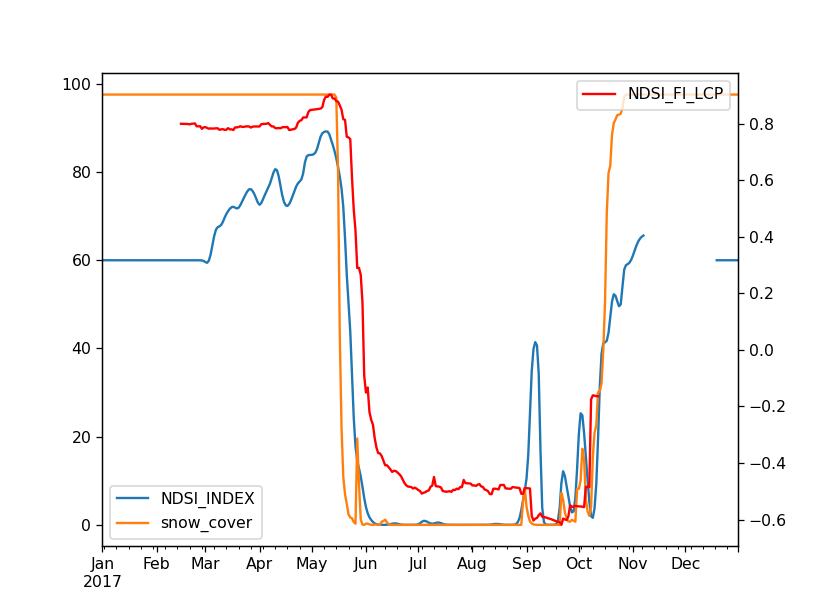

,snow_cover,NDSI_FI_LCP
snow_cover,1.000000,0.825682
NDSI_FI_LCP,0.825682,1.000000


In [15]:
fig,ax=plt.subplots()
Daily.loc[Daily.index.year==2017,['NDSI_INDEX','snow_cover']].plot(ax=ax)
ax2=ax.twinx()

Daily.loc[Daily.index.year==2017,['NDSI_FI_LCP']].plot(ax=ax2,color='r')

Daily[['snow_cover','NDSI_FI_LCP']].corr()**2#'NDSI_INDEX',

# plt.figure()
# plt.scatter(Daily['NDSI_INDEX'],Daily['NDSI_FI_LCP'])



In [16]:
# Daily['Snow_Season1'] = 'Winter'
# Daily['Snow_Season2'] = 'Winter'

# for y in range(2008,2021):
#     Thresh = Daily.loc[((Daily.index.year==y)&(Daily.index.month==4)),
#                       'NDSI_fill'].quantile(0)
#     Thresh2 = Daily.loc[((Daily['NDSI_fill']>=Thresh)&(Daily.index.year==y)&
#                          (Daily.index.month>=5)&(Daily.index.month<=6)),
#                       'DOY'][-1]
#     Daily.loc[((Daily['NDSI_fill']<Thresh)&(Daily.index.year==y)&
#                (Daily.index.dayofyear>Thresh2)&(Daily.index.month<=6)),
#                       'Snow_Season1'] = 'Snow Melt'
#     Daily.loc[((Daily['NDSI_fill']<.5)&(Daily.index.year==y)&(Daily.index.month>=5)),
#                       'Snow_Season1'] = 'Snow Free'
    
#     Daily.loc[((Daily['snow_cover']<25)&(Daily.index.year==y)),
#                       'Snow_Season2'] = 'Snow Free'
    
# #     D1 = Daily.loc[((Daily['snow_cover']<30)&(Daily.index.year==y))].index.dayofyear[0]
# #     D2 = Daily.loc[((Daily['snow_cover']<30)&(Daily.index.year==y))].index.dayofyear[-1]
    
# #     Daily.loc[((Daily.index.dayofyear>=D1)&(Daily.index.dayofyear<=D2)&(Daily.index.year==y)),
# #                       'Snow_Season2'] = 'Snow Free'
    
    


# Daily['Snow_Season'] = Daily['Snow_Season2'].copy()
# Daily.loc[((Daily.index.month>=7)&(Daily['Snow_Season2']=='Winter')),'Snow_Season']='Winter'

# Daily['Growing_Season']=Daily['Snow_Season'].copy()


# GS_Thresh = 0.25
# for y in range(2008,2021):
#     Thresh = Daily.loc[((Daily.index.year==y)),#&(Daily.index.month==4)),
#                       'NDVI_fill'].max()
#     Thresh2 = Daily.loc[((Daily.index.year==y)&(Daily.NDVI_fill==Thresh))].index[0]
    
#     Daily.loc[((Daily.index.year==y)&(Daily.index>Thresh2)&(Daily['NDVI_FI_LCP']>GS_Thresh)&
#                (Daily['Snow_Season']!='Winter')),
#                       'Growing_Season'] = 'Sensecence'
#     Daily.loc[((Daily.index.year==y)&(Daily.index<Thresh2)&(Daily['NDVI_FI_LCP']>GS_Thresh)&
#                (Daily['Snow_Season']!='Winter')),
#                       'Growing_Season'] = 'Early Season'
#     Daily.loc[((Daily.index.year==y)&(Daily['NDVI_FI_LCP']/Thresh>0.9)),
#                       'Growing_Season'] = 'Peak Season'

# Thresh = 0
# Daily['Warm'] = 0
# Daily.loc[(Daily.Air_Temp>Thresh),'Warm']=1


# Daily['Year']=Daily.index.year
# Daily['Growing_Season']=Daily['Growing_Season'].replace({'Snow Free':'Green Up'})

# # Daily['Season']=Daily['Warm']*1
# # Daily.loc[Daily['Snow_Season']!='Snow Free','Season']=0

# Daily['Season'] = 0
# # Daily['Study_Season']=-1
# Daily.loc[Daily['Snow_Season']=='Snow Free','Season']=1
# # Daily.loc[Daily['Snow_Season']=='Snow Melt','Season']=1
# # Daily.loc[Daily['Snow_Season']=='Snow Free','Study_Season']=1
# # Daily.loc[Daily['Snow_Season']=='Snow Melt','Study_Season']=0
# Daily['Season'] = Daily['Season'] * Daily['Warm'] 

# FDF = pd.DataFrame(data={})

# FDF['Start'] = Daily.loc[Daily['Season']==1].resample('Y').first()['Date']
# FDF['Start_doy'] = Daily.loc[Daily['Season']==1].resample('Y').first()['DOY']

# FDF['End'] = Daily.loc[Daily['Season']==1].resample('Y').last()['Date']


# Daily['Study_Season']=0
# for i,row in FDF.iterrows():
#     Daily.loc[((Daily.index.date>=row['Start'])&(Daily.index.date<=row['End'])),'Study_Season']=1


# FDF['Start_NDSI'] = Daily.loc[Daily['Snow_Season1']=='Snow Free'].resample('Y').first()['Date']
# FDF['Start_NDSI_DOY'] = Daily.loc[Daily['Snow_Season1']=='Snow Free'].resample('Y').first()['DOY']


# print((FDF['Start']-FDF['Start_NDSI']).describe())

# FDF.index=FDF.index.year

# Daily.resample('Y').sum()[['Study_Season','Season']].astype(int)
# # Daily.index

# print(Daily.loc[(Daily['Study_Season']==1)&(Daily['Snow_Season']=='Winter'),'snow_cover'])

# # FDF
# # Daily.loc[Daily.index.year==2013,['Study_Season','snow_cover','NDSI_fill','Air_Temp','Snow_Season',
# #                                   ]].dropna()
# # print(Daily.loc[((Daily['Snow_Season2']=='Winter')&(Daily['Snow_Season']=='Snow Free')),'Air_Temp'].count())

In [44]:
Daily['Snow_Season1'] = 'Winter'
Daily['Snow_Season2'] = 'Winter'

for y in range(2008,2021):
    Thresh = Daily.loc[((Daily.index.year==y)&(Daily.index.month==4)),
                      'NDSI_fill'].quantile(0)
    Thresh2 = Daily.loc[((Daily['NDSI_fill']>=Thresh)&(Daily.index.year==y)&
                         (Daily.index.month>=5)&(Daily.index.month<=6)),
                      'DOY'][-1]
    Daily.loc[((Daily['NDSI_fill']<Thresh)&(Daily.index.year==y)&
               (Daily.index.dayofyear>Thresh2)&(Daily.index.month<=6)),
                      'Snow_Season1'] = 'Snow Melt'
    Daily.loc[((Daily['NDSI_fill']<.5)&(Daily.index.year==y)&(Daily.index.month>=5)),
                      'Snow_Season1'] = 'Snow Free'
    
    Daily.loc[((Daily['snow_cover']<15)&(Daily.index.year==y)),
                      'Snow_Season2'] = 'Snow Free'
    

Daily['Snow_Season'] = Daily['Snow_Season2'].copy()
Daily.loc[((Daily.index.month>=7)&(Daily['Snow_Season2']=='Winter')),'Snow_Season']='Winter'

Daily['Growing_Season']=Daily['Snow_Season'].copy()


GS_Thresh = 0.25
for y in range(2008,2021):
    Thresh = Daily.loc[((Daily.index.year==y)),#&(Daily.index.month==4)),
                      'NDVI_fill'].max()
    Thresh2 = Daily.loc[((Daily.index.year==y)&(Daily.NDVI_fill==Thresh))].index[0]
    
    Daily.loc[((Daily.index.year==y)&(Daily.index>Thresh2)&(Daily['NDVI_FI_LCP']>GS_Thresh)&
               (Daily['Snow_Season']!='Winter')),
                      'Growing_Season'] = 'Sensecence'
    Daily.loc[((Daily.index.year==y)&(Daily.index<Thresh2)&(Daily['NDVI_FI_LCP']>GS_Thresh)&
               (Daily['Snow_Season']!='Winter')),
                      'Growing_Season'] = 'Early Season'
    Daily.loc[((Daily.index.year==y)&(Daily['NDVI_FI_LCP']/Thresh>0.9)),
                      'Growing_Season'] = 'Peak Season'

Thresh = 0
Daily['Warm'] = 0
Daily.loc[(Daily.Air_Temp>Thresh),'Warm']=1


FDF = pd.DataFrame(data={})

FDF['Start'] = Daily.loc[Daily['Snow_Season']=='Snow Free'].resample('Y').first()['Date']
FDF['Start2'] = Daily.loc[Daily['Snow_Season1']=='Snow Free'].resample('Y').first()['Date']
FDF['Start_doy'] = Daily.loc[Daily['Snow_Season']=='Snow Free'].resample('Y').first()['DOY']

FDF['End'] = Daily.loc[Daily['Snow_Season']=='Snow Free'].resample('Y').last()['Date']

# print(FDF)
Daily['Study_Season']=0
for i,row in FDF.iterrows():
    Daily.loc[((Daily.index.date>=row['Start'])&(Daily.index.date<=row['End'])),'Study_Season']=1



Daily['Year']=Daily.index.year
Daily['Growing_Season']=Daily['Growing_Season'].replace({'Snow Free':'Green Up'})

# Daily['Season']=Daily['Warm']*1
# Daily.loc[Daily['Snow_Season']!='Snow Free','Season']=0

Daily['Season'] = 0
# Daily['Study_Season']=-1
Daily.loc[Daily['Snow_Season']=='Snow Free','Season']=1
FDF.index=FDF.index.year

# print(Daily.loc[(Daily['Study_Season']==1)&(Daily['Snow_Season']=='Winter'),'snow_cover'])

(FDF['Start']-FDF['Start2']).describe()
# Daily.loc[Daily.index.year==2013,['Study_Season','snow_cover','NDSI_fill','Air_Temp','Snow_Season',
#                                   ]].dropna()
# FDF
# # print(Daily.loc[((Daily['Snow_Season2']=='Winter')&(Daily['Snow_Season']=='Snow Free')),'Air_Temp'].count())
# Daily['Study_Season'].max()

count                             13
mean     -6 days +14:46:09.230769231
std        4 days 13:20:31.518437856
min               -12 days +00:00:00
25%                -9 days +00:00:00
50%                -6 days +00:00:00
75%                -2 days +00:00:00
max                  5 days 00:00:00
dtype: object

# Flood

In [18]:
for y in range(2008,2021):
    Y = Daily.loc[Daily.index.year==y].copy()
    Y['T']=(Y['Air_Temp']*Y['Season']).cumsum()
    Daily.loc[Daily.index.year==y,'T_Sum'] = Y['T']#(Y['T']**.5).ffill()
#     Y['T']=(Y['Season']*Y['Air_Temp']**5).cumsum()
    Daily.loc[Daily.index.year==y,'T_Sum_Root'] = (Y['T']**.5).ffill()
    

Exp = 1/2

for y in range(2009,2021):
    Year = Daily.loc[Daily.index.year==y].copy()
    Year['Season_Sum'] = ((Year['Warm']+Year['Study_Season'])/2).cumsum()#*Year['Study_Season']
#     print(Year['Season_Sum'].describe())
    Year['Season'] = 0
    Year.loc[Year['Season_Sum']>0,'Season']=1
#     Year['Season'].cumsum()
    Daily.loc[Daily.index.year==y,'Season_Sum']=Year['Season_Sum']*1
    Daily.loc[Daily.index.year==y,'Season_Root']=Year['Season_Sum']**Exp
    FDF.loc[FDF.index==y,'Season_Sum']=Year['Season_Sum'].max()
    FDF.loc[FDF.index==y,'T_Sum']=Year['T_Sum'].max()
    FDF.loc[FDF.index==y,'T_Sum_Root']=Year['T_Sum_Root'].max()
    FDF.loc[FDF.index==y,'Season_Root']=Year['Season_Sum'].max()**Exp
    Daily.loc[Daily.index.year==y,'Season']=Year['Season']

FDF['Season_Root']=FDF['Season_Sum']**Exp

AL_obs = pd.read_csv(Output_Path+'AL_obs.csv',index_col=['Date'],parse_dates=['Date'])

AL_s = ['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)','Taglu (grid)']

ALH=pd.read_csv(Output_Path+'AL_Depth.csv',header=[1])
AL=pd.read_csv(Output_Path+'AL_Depth.csv',skiprows=4)
AL.columns=ALH.columns
AL=AL.rename(columns={'Name':'Year'})
AL = AL.set_index('Year')
AL[AL_s]/=100

AL = AL.loc[AL.index>=2009,AL_s]

T = Daily.loc[Daily.index.year>=2008].resample('Y').mean()[['Air_Temp']]
T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T).join(FDF)
Flood = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=6))].copy()
for y in range(2009,2019):
    Fy=Flood.loc[Flood.index.year==y].copy()
#     Sf=Daily.loc[((Daily.index.year==y)&(Daily.index.month>=7))].copy()
    for s in ['KULUARPAK','BIG LAKE']:
        if Fy[s].count()/(1464/24)>.3:
            if s == 'KULUARPAK' and y == 2010:
                pass
            else:
                v=Fy[s].max()
                d = Fy.loc[((Fy[s]==v))].index.date
                doy = Fy.loc[((Fy[s]==v))].index.dayofyear
                FDF.loc[FDF.index==y,s+'_Peak']=v
                FDF.loc[FDF.index==y,s+'_Peak_Date']=d
                FDF.loc[FDF.index==y,s+'_Peak_doy']=doy

for y,row in FDF.iterrows():
    Year = Daily.loc[Daily.index.year == y]
    S = (Daily.loc[((Daily.index==row['BIG LAKE_Peak_Date'])|(Daily.index==row['KULUARPAK_Peak_Date'])),
                   ['NDVI_FI_LCP']].max())
    FDF.loc[FDF.index==y,'NDVI']=S.values
    S = (Daily.loc[((Daily.index==row['BIG LAKE_Peak_Date'])|(Daily.index==row['KULUARPAK_Peak_Date'])),
                   ['NDSI_FI_LCP']].min())
    FDF.loc[FDF.index==y,'NDSI']=S.values
#     print(S)
# FDF['NDSI'].describe()
Temp = FDF.dropna()

# FDF['BIG LAKE_Peak_Date'] = FDF['BIG LAKE_Peak_Date'].fillna(FDF['KULUARPAK_Peak_Date'] + timedelta(days=1))
FDF['BIG LAKE_Peak_doy'] = FDF['BIG LAKE_Peak_doy'].fillna(FDF['KULUARPAK_Peak_doy'] + 1)#timedelta(days=1))


print((FDF['Start']-FDF['KULUARPAK_Peak_Date']).describe())
print((FDF['Start']-FDF['BIG LAKE_Peak_Date']).describe())
print((FDF['KULUARPAK_Peak_Date']-FDF['BIG LAKE_Peak_Date']).describe())
# # Temp
# print(FDF[['Start_doy','BIG LAKE_Peak_doy','KULUARPAK_Peak_doy']].corr()**2)


print(FDF[['BIG LAKE_Peak_doy','KULUARPAK_Peak_doy',
#            'Start_NDSI_DOY',
           'Start_doy']].corr()['Start_doy']**2)

# FDF[['KULUARPAK_Peak_doy','KULUARPAK_Peak','BIG LAKE_Peak_doy','BIG LAKE_Peak']].describe()

# FDF[['BIG LAKE_Peak_Date','BIG LAKE_Peak_doy']].sort_values(by='BIG LAKE_Peak_doy')
# FDF[['KULUARPAK_Peak_Date','KULUARPAK_Peak_doy']].sort_values(by='KULUARPAK_Peak_doy')
# FDF['KD'] = FDF['KULUARPAK_Peak_Date'].dayofyear
Daily['Study_Season'].describe()
# FDF

# Daily.loc[Daily['Season']==1].resample('Y').first()['Date']

count                            8
mean             -9 days +00:00:00
std      2 days 22:15:53.298908259
min             -14 days +00:00:00
25%             -11 days +00:00:00
50%              -9 days +12:00:00
75%              -7 days +06:00:00
max              -6 days +00:00:00
dtype: object
count                               7
mean     -11 days +13:42:51.428571429
std         3 days 20:48:14.186890891
min                -16 days +00:00:00
25%                -14 days +12:00:00
50%                 -8 days +00:00:00
75%                 -8 days +12:00:00
max                 -7 days +00:00:00
dtype: object
count                            6
mean             -2 days +20:00:00
std      0 days 09:47:52.652296077
min              -2 days +00:00:00
25%              -1 days +00:00:00
50%              -1 days +00:00:00
75%              -1 days +00:00:00
max              -1 days +00:00:00
dtype: object
BIG LAKE_Peak_doy     0.783057
KULUARPAK_Peak_doy    0.904356
Start_doy             1.000000
N

count    4749.000000
mean        0.367025
std         0.482044
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Study_Season, dtype: float64

In [19]:
v = 'Season_Root'
# v = 'Season_Sum'
# v = 'T_Sum'
# v = 'T_Sum_Root'
param = v


X = [param]


print('AL Comparisson')
print(AL_s[0])
df = AL[[AL_s[0]]+X].dropna()
# print(df)
Mod = LinearRegression()
Mod.fit(df[X], df[AL_s[0]])
print(Mod.coef_)
Test = Mod.predict(df[X])
print(metrics.r2_score(df[AL_s[0]],Test))

print()
print(AL_s[1])
df = AL[[AL_s[1]]+X].dropna()
Mod = LinearRegression()
Mod.fit(df[X], df[AL_s[1]])
print(Mod.coef_)
Test = Mod.predict(df[X])
print(metrics.r2_score(df[AL_s[1]],Test))
AL = AL.loc[AL.index>=2008].copy()
# AL


Data.loc[((Data.index.month<=4)|(Data.index.month>=11)),['Season','Season_Sum','Season_Root','T_Sum','Study_Season']]=np.nan
Data.loc[Data['Study_Season'].isnull(),['Season_Sum','Season_Root','T_Sum','Study_Season']]=np.nan

for v in ['DOY','Season_Sum','Season_Root','T_Sum','T_Sum_Root']:
    for d in AL_obs.index.unique():
        AL_obs.loc[AL_obs.index==d,v]=Daily.loc[Daily.index.date==d,v].values[0]

y=['Active_Layer_1']
Y = 'AL_data_est'
Lag = []
D = []
K = 10


Val,C,I,RMSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')#,fit_intercept=False)
AL_obs[Y]=Val
try:
    Daily['AL_data_est'] = (Daily[X[0]])*C[0]+(Daily[X[1]])*C[1]+I
except:
    Daily['AL_data_est'] = (Daily[X[0]])*C[0]+I
    pass
Data['AL_data_est']=Daily['AL_data_est'].resample('H').interpolate()
Data['Season']=Daily['Season'].resample('H').bfill()
Data['Study_Season']=Daily['Study_Season'].resample('H').interpolate()
Data.loc[Data['Study_Season']<1,'Study_Season']=np.nan

# Data['AL_data_est']*=Data['Study_Season']
Data.loc[Data['AL_data_est']<=0,'AL_data_est']=0
# Data.loc[Data['AL_data_est']>0,'Study_Season']=1

T = Daily.loc[Daily.index.year>=2008].resample('Y').max()[['AL_data_est']]
T['Year']=T.index.year
T = T.set_index('Year')
try:
    AL = AL.drop(columns='AL_data_est')
except:
    pass
AL = AL.join(T)
AL = AL.loc[AL['AL_data_est'].isnull()==False].copy()

# print(Daily.loc[Daily['Snow_Season']=='Snow Free','AL_data_est'].resample('Y').min())
print()
print((AL.loc[AL.index>=2009,['AL_data_est']+AL_s].corr()**2)['AL_data_est'])
# print(AL.loc[AL.index>=2009,AL_s].corr()**2)
# print(Daily)
print(AL[AL_s].mean())
print()
print(Data.loc[Data.index.year==2017,'AL_data_est'].max())
# plt.figure()
# plt.plot(Data['AL_data_est'],marker='*')

AL Comparisson
Reindeer Depot  (Thaw tube)
        Reindeer Depot  (Thaw tube)  Season_Root
Year                                            
2009.0                         1.29    11.022704
2010.0                         1.37    11.335784
2011.0                         1.38    11.489125
2012.0                         1.54    11.895377
2013.0                         1.50    12.041595
2014.0                         1.44    11.467345
2015.0                         1.46    11.704700
2016.0                         1.51    12.144958
2017.0                         1.45    11.895377
[0.19825679]
0.8425346786446323

Lousy Point (Thaw tube)
[0.10117193]
0.44515188566445807

Active_Layer_1
RMSE 0.022693593964012177
std RMSE 0.006047043861602656
r2 0.9292132121777429
coef [0.05721371]
int -0.11713310497761371

AL_data_est                    1.000000
Reindeer Depot  (Thaw tube)    0.842535
Lousy Point (Thaw tube)        0.445152
Taglu (grid)                   0.023918
Name: AL_data_est, dtype: floa

In [43]:
# plt.figure()
# plt.plot(Daily.loc[Daily.index.year==2016,'snow_cover'])
# plt.plot(Daily.loc[Daily.index.year==2016,'NDVI_fill']*100)
# plt.plot(Daily.loc[Daily.index.year==2016,'Season_Sum'])

Season_Root
DOY               0.962242
Season_Root       0.952841
Season_Sum        0.962242
Active_Layer_1    1.000000
Name: Active_Layer_1, dtype: float64

Active_Layer_1
RMSE 0.02012297971743496
std RMSE 0.006195651834781041
r2 0.9424498854788228
coef [0.00347315]
int -0.3787794038548565
[0.14219306 0.14566621 0.14913936 0.15261251 0.15608566 0.15955881
 0.16303196 0.16650511 0.16997826 0.17345141 0.17692456 0.18039771
 0.18387086 0.18734401 0.19081716 0.19429031 0.19776346 0.20123661
 0.20470976 0.20818291 0.21165606 0.21512921 0.21860236 0.22207551
 0.22554866]
Season_Root

Active_Layer_1
RMSE 0.022693593964012177
std RMSE 0.006047043861602656
r2 0.9292132121777429
coef [0.05721371]
int -0.11713310497761371


[-0.1171331  -0.0599194  -0.03622071 -0.01803606 -0.00270569  0.01080063
  0.02301128  0.03424013  0.04469169  0.05450801]


<IPython.core.display.Javascript object>


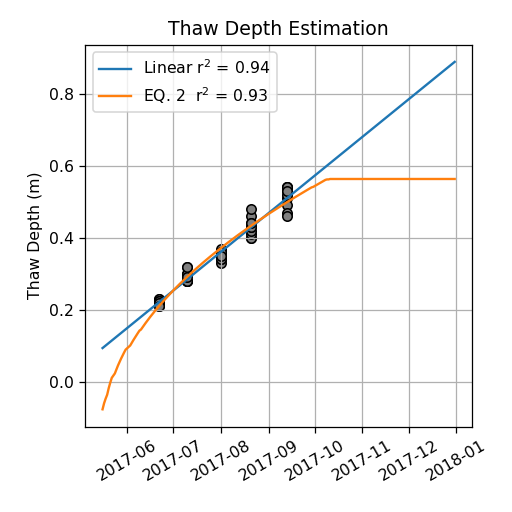

In [21]:
print(param)
print(AL_obs[['DOY','Season_Root','Season_Sum','Active_Layer_1']].corr()['Active_Layer_1']**2)
y = ['Active_Layer_1']

X = ['DOY']
Val,C1,I1,MSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')

Daily['DSSM'] = Daily.index.dayofyear-152
Sub = Daily.loc[((Daily.index.year==2017)&(Daily.Season>=1))]


print(C1*np.arange(150,175)+I1)

print(param)
X = [param]
Val,C,I,MSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')#,fit_intercept=False)

print()
print()
print(C*np.arange(0,10)**.5+I)

fig,ax=plt.subplots(figsize=(4,4)) 
plt.plot(Sub.index,Sub['DOY']*C1+I1,label='Linear r$^2$ = 0.94')
plt.plot(Sub.index,(Sub[X])*C+I,label='EQ. 2  r$^2$ = 0.93')

plt.scatter(AL_obs.index, AL_obs['Active_Layer_1'],color='grey',edgecolor='k')
ax.set_title('Thaw Depth Estimation')

ax.set_ylabel('Thaw Depth (m)')
ax.legend()

plt.grid()
# plt.ylim(0,0.65)
fig.autofmt_xdate(ha='center')
plt.tight_layout()
plt.savefig(G_Drive+'/PhD_Thesis/Chapter3_Figs/AL_fig.png',dpi=600)

# Fill Params

<IPython.core.display.Javascript object>


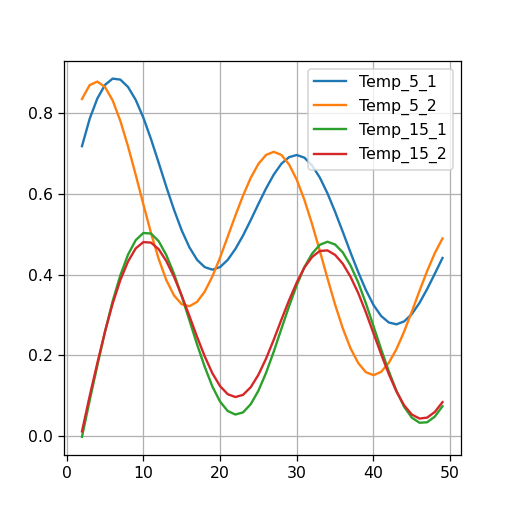

In [22]:
H = 48
C = pd.DataFrame(data={
    'Temp_5_1':np.zeros(H),
    'Temp_5_2':np.zeros(H),
    'Temp_15_1':np.zeros(H),
    'Temp_15_2':np.zeros(H)
},
     index=np.arange(1,H+1))
for h in range(0,H):
    for c in C.columns:
        Data['Rolling_Temp'] = Data['Air_Temp'].shift(h+1)#.mean()
        C.iloc[h][c] = (Data[['Rolling_Temp',c]].corr()['Rolling_Temp'][-1]).copy()
fig,ax=plt.subplots(figsize=(4,4))
C.index=C.index+1
C.plot(ax=ax)
plt.grid()
# C.diff().plot(ax=ax)
# C.loc[C.diff()['Temp_5_2']<=0]

# Final?

In [23]:
L = [3,6,12,24,48]
Data['Level_1']=Data['soil_temperature_level_1'].rolling(str(24)+'H').mean()
Data['Level_2']=Data['soil_temperature_level_2'].rolling(str(24)+'H').mean()
Data['Level_3']=Data['soil_temperature_level_3'].rolling(str(24)+'H').mean()

Data['Level_1_VWC']=Data['volumetric_soil_water_layer_1'].rolling(str(24)+'H').mean()
Data['Level_2_VWC']=Data['volumetric_soil_water_layer_2'].rolling(str(24)+'H').mean()

Data['Rolling_RainfallD3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_RainfallD1']=Data['Rainfall'].rolling(str(1)+'D').sum()

Lags = []
for l in L:
#     Lags.append('Shift_Air_Temp_'+str(l))
#     Data['Shift_Air_Temp_'+str(l)] = Data['Air_Temp'].shift(l)#str(l)+'H')#.mean()
    Lags.append('Rolling_Air_Temp_'+str(l))
    Data['Rolling_Air_Temp_'+str(l)] = Data['Air_Temp'].rolling(str(l)+'H').mean()
for d in ['Rolling_RainfallD1','Rolling_RainfallD3']:
    Lags.append(d)
    
Y = 'Test'

SE_Rule = 3

Met = [
    'Net_SW',
    'Net_LW',
#     'Net_RN',
    'Air_Temp',
#     'Rainfall'
    ]
Met = Met + Lags

ERA5 = [
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    ]

AllX = ERA5+Met#+Lag_Rain
# AllX = Met#+Lag_Rain

print(len(AllX))

Mods = {
}
for y,Z in zip([['Table_1'],['Temp_15_1'],['Temp_15_2'],['Temp_5_1'],['Temp_5_2']],[1,4,5,2,3]):
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
#              'Z':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]
            }
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2))/(MSE.shape[0]**.5))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std()/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
#     Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2']][-1:]
#     Sel = Track.loc[Track['RMSE']/Track['RMSE'].min()>1.05,['RMSE','RMSES','R2']][0:1]
    Sel = Track.loc[Track['R2']/Track['R2'].max()>=0.95,['RMSE','RMSES','R2','R2S','R2SS']][-1:]
#     Sel = Track.loc[Track['R2SS']/Track['R2SS'].max()>0.98,['RMSE','RMSES','R2','R2S','R2SS']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    Mods[y[0]]['Z']=Z
    print(y[0])
    print()
    print(M)
    print()
    print(Sel.round(2))
    print('Max: ',Track['R2'].max().round(2))
    

    print()
    print()

15
Table_1

['soil_temperature_level_3' 'volumetric_soil_water_layer_1'
 'volumetric_soil_water_layer_2']

   RMSE  RMSES    R2  R2S  R2SS
i                              
3  0.01    0.0  0.93  0.0  0.92
Max:  0.96


Temp_15_1

['volumetric_soil_water_layer_2' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_Temp_6' 'Net_SW']

   RMSE  RMSES    R2  R2S  R2SS
i                              
5  0.47   0.01  0.89  0.0  0.88
Max:  0.93


Temp_15_2

['volumetric_soil_water_layer_2' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_Temp_6' 'Net_SW']

   RMSE  RMSES    R2   R2S  R2SS
i                               
5  0.53   0.01  0.86  0.01  0.84
Max:  0.9


Temp_5_1

['soil_temperature_level_3' 'Air_Temp' 'Rolling_Air_Temp_6']

   RMSE  RMSES    R2  R2S  R2SS
i                              
3  0.81   0.01  0.88  0.0  0.87
Max:  0.91


Temp_5_2

['Net_LW' 'Net_SW' 'Rolling_Air_Temp_6' 'soil_temperature_level_1'
 'Air_Temp' 'Rolling_Air_Temp_3']

   RMSE  RMSES    R2  R2S  R2SS
i        

In [24]:
Rec = {'Y':[],
      'R2':[]}
for x in AllX:
    Rec[x]=[]
    
for Y in Mods.keys():
    Rec['Y'].append(Y)
    X = list(Mods[Y]['X'])
    y = [Y]
    res = {
    'X':X,
    'Score':np.ones(len(X))/len(X),
    'Z':np.ones(len(X))
    }
    Results = pd.DataFrame(data=res)
    Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
    Results['Score'] = np.abs(C)/(np.abs(C)).sum()
    Results['Score'] = Results['Score'].round(2)
#     for i,row in Results.iterrows():
#         
    for c in AllX:
#         v = 0
        if Results.loc[Results['X']==c,'Score'].shape[0]>0:
            v = Results.loc[Results['X']==c,'Score'].values[0]
            v = str(int(v*100))+'%'
        else:
            v = '--'
#             pass
        Rec[c].append(v) 
    Rec['R2'].append(Mods[Y]['Stats']['R2'].round(2).values[0])

# print(Rec)
Rec = pd.DataFrame(data=Rec)
# Rec

Rec = Rec.rename(columns={'soil_temperature_level_1':'Ts Level 1',# (0 - 7 cm)',
                                      'soil_temperature_level_2':'Ts Level 2',# (7 - 28 cm)',
                                      'soil_temperature_level_3':'Ts Level 3',# (7 - 28 cm)',
                                      'volumetric_soil_water_layer_1':'Theta Level 1',# (7 - 28 cm)',
                                      'volumetric_soil_water_layer_2':'Theta Level 2',# (7 - 28 cm)',
                                      'Air_Temp':'Ta',
                                        'Net_SW':'SW',
                                        'Net_LW':'LW',
                                        'Rolling_Air_Temp_48':'Mean Ta 48 hr',
                                        'Rolling_Air_Temp_24':'Mean Ta 24 hr',
                                        'Rolling_Air_Temp_12':'Mean Ta 12 hr',
                                        'Rolling_Air_Temp_6':'Mean Ta 6 hr',
                                        'Rolling_Air_Temp_3':'Mean Ta 3 hr',
                                        'Rolling_RainfallD3':'Total Rainfall 3 D',
                                        'Rolling_RainfallD1':'Total Rainfall 1 D'})
Rec['Y'] = Rec['Y'].replace({'Temp_5_1':'Polygon Center 5 cm',
                                   'Temp_5_2':'Polygon Rim 5 cm',
                                   'Temp_15_1':'Polygon Center 15 cm',
                                   'Temp_15_2':'Polygon Rim 15 cm',
                                    'Table_1':'Wtd'
                                  })
Rec.set_index(['Y','R2']).T
# print(AllX)

Y,Wtd,Polygon Center 15 cm,Polygon Rim 15 cm,Polygon Center 5 cm,Polygon Rim 5 cm
R2,0.93,0.89,0.86,0.88,0.88
Ts Level 1,--,--,--,--,13%
Ts Level 2,--,--,--,--,--
Ts Level 3,20%,16%,18%,11%,--
Theta Level 1,45%,--,--,--,--
Theta Level 2,35%,7%,8%,--,--
SW,--,20%,15%,--,8%
LW,--,--,--,--,8%
Ta,--,23%,25%,34%,31%
Mean Ta 3 hr,--,--,--,--,16%


<IPython.core.display.Javascript object>


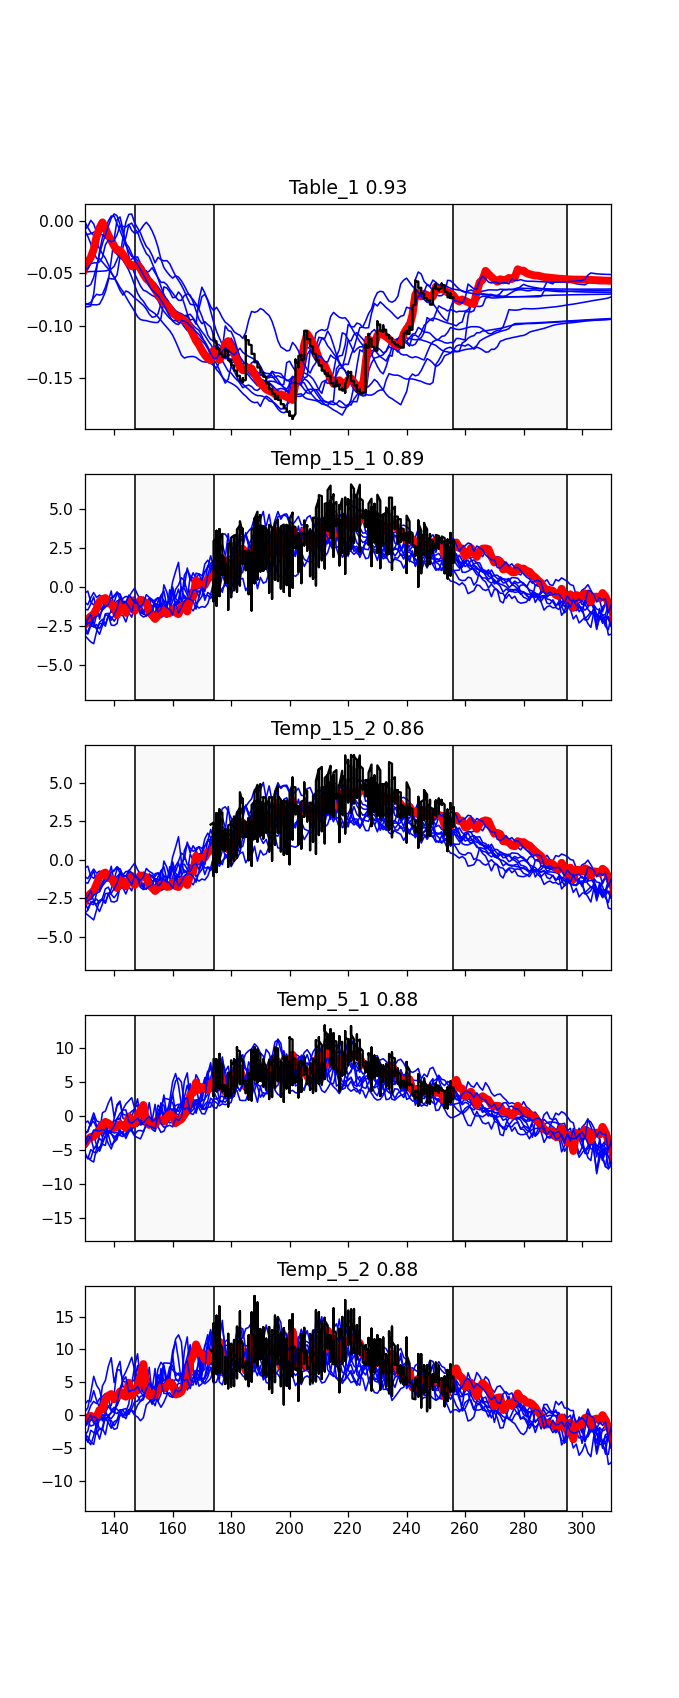

       RMSE     RMSES        R2      R2S      R2SS
i                                                 
3  0.008395  0.000202  0.933515  0.00403  0.921426

r2:  0.9348390975423464
RMSE:  0.008402939484781127
       RMSE     RMSES        R2       R2S      R2SS
i                                                  
5  0.466173  0.005114  0.894321  0.003626  0.883442

r2:  0.8963295474999626
RMSE:  0.46521418274008397
      RMSE     RMSES        R2       R2S      R2SS
i                                                 
5  0.52723  0.010495  0.864002  0.006702  0.843896

r2:  0.8662014009231631
RMSE:  0.5264793003267267
       RMSE     RMSES        R2       R2S     R2SS
i                                                 
3  0.806926  0.007279  0.883755  0.003215  0.87411

r2:  0.8856357203319244
RMSE:  0.8053131754095524
       RMSE    RMSES        R2       R2S      R2SS
i                                                 
6  1.164361  0.01892  0.875505  0.004187  0.862945

r2:  0.877945380525764
R

In [25]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    res = {
    'X':X,
    'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=False)
#     Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
#                              Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
    
#     Results['Score'] = np.abs(C)/(np.abs(C)).sum()
#     Results = Results.sort_values('Score')
#     print(Results.sort_values(by='Score'))
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].set_xlim(130,310)
    j +=1

In [26]:
# print(Data['Study_Season'].resample('Y').max())

# print(Data_d.loc[Data_d['AL_data_est']>0.15]
Data['DOY']=Data.index.dayofyear
D = Data.resample('D').mean()
print(D.loc[D['Temp_5_1_OLS']>0].resample('Y').first()[['AL_data_est','Temp_5_1_OLS','Temp_15_2_OLS','DOY']].mean())
print(D.loc[D['Temp_15_1_OLS']>0].resample('Y').first()[['AL_data_est','Temp_5_1_OLS','Temp_15_2_OLS','DOY']].mean())
print(D.loc[D['AL_data_est']>0.05].resample('Y').first()[['Temp_5_1_OLS','Temp_15_2_OLS','DOY']].mean())
print(D.loc[D['AL_data_est']>0.15].resample('Y').first()[['Temp_5_1_OLS','Temp_15_2_OLS','DOY']].mean())

AL_data_est        0.045818
Temp_5_1_OLS       0.876190
Temp_15_2_OLS     -0.925901
DOY              155.846154
dtype: float64
AL_data_est        0.173278
Temp_5_1_OLS       3.960630
Temp_15_2_OLS      0.366207
DOY              173.153846
dtype: float64
Temp_5_1_OLS      -0.333094
Temp_15_2_OLS     -1.601777
DOY              149.916667
dtype: float64
Temp_5_1_OLS       1.381914
Temp_15_2_OLS     -0.886158
DOY              163.833333
dtype: float64


In [27]:
Y = 'Test'
SE_Rule = 1
Met = [
    'Net_LW',
    'Net_SW',
    'Wind_Speed',
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'Wind_10m',
    'HH',
    ]
AllX = Met+ERA5_Met
print(len(AllX))
Mods = {}
for y in [['u*'],['PPFD_Avg'],['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
             'Int':[],
             'Coef':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['Int'].append(np.mean(np.array(I)))
        Track['Coef'].append(np.mean(np.array(C)))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S','Coef','Int']][-1:]
    Sel = Track.loc[Track['R2']/Track['R2'].max()>0.98,['RMSE','RMSES','R2']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
#     print(Track)
    print()

8
['u*']
['Wind_Speed']
       RMSE     RMSES       R2
i                             
1  0.045001  0.003854  0.89794

['PPFD_Avg']
['Net_SW']
        RMSE     RMSES       R2
i                              
1  38.631624  2.556721  0.99004

['VPD']
['temperature_2m' 'dewpoint_temperature_2m' 'Air_Temp']
         RMSE     RMSES        R2
i                                
3  131.354226  8.698229  0.876402



In [28]:
X = ['Wind_Speed']
y = ['u*']
Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                     Test = 'OLS',Scale=False,Task='Predict_Return',Verbose=True)

X = ['Net_SW']
y = ['PPFD_Avg']
Data['Net_SW_T'] = Data['Net_SW'].copy()
Data.loc[Data['Net_SW_T']<0,'Net_SW_T']=0
Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                     Test = 'OLS',Scale=False,Task='Predict_Return',Verbose=True)


u*
RMSE 0.04500149440521988
std RMSE 0.0038542468485703867
r2 0.8948652491619089
coef [0.07370356]
int 0.021367641498866184

PPFD_Avg
RMSE 38.63162448677514
std RMSE 2.5567209462702647
r2 0.9904007390827857
coef [2.38028641]
int 3.848866329466529


<IPython.core.display.Javascript object>


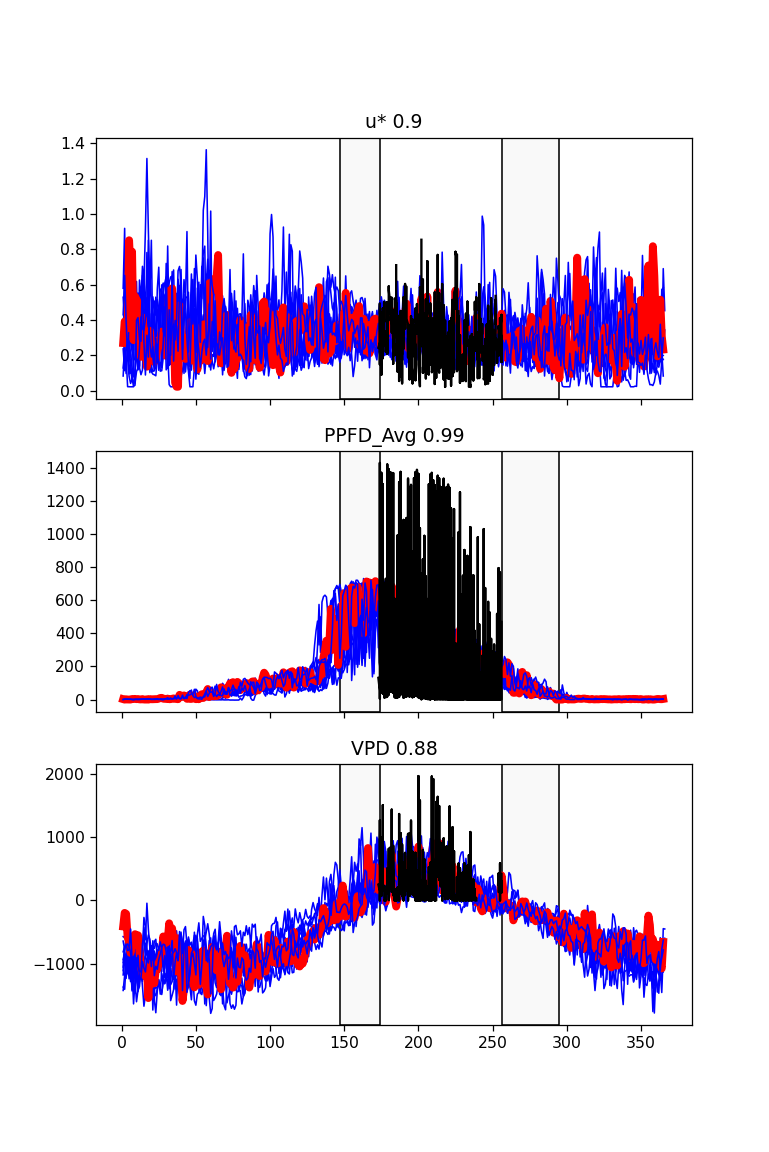

       RMSE     RMSES       R2
i                             
1  0.045001  0.003854  0.89794

u*
RMSE 0.04500149440521988
std RMSE 0.0038542468485703893
r2 0.8948652491619089
coef [0.13501616]
int 0.3044481420598676

r2:  0.8998657373147907
RMSE:  0.045041291088142706
        RMSE     RMSES       R2
i                              
1  38.631624  2.556721  0.99004

PPFD_Avg
RMSE 38.63162448677515
std RMSE 2.556720946270257
r2 0.9904007390827857
coef [389.66543789]
int 333.84664621212124

r2:  0.990258864514813
RMSE:  38.64921631423895
         RMSE     RMSES        R2
i                                
3  131.354226  8.698229  0.876402

VPD
RMSE 131.3542258113198
std RMSE 8.698228786674118
r2 0.8750078566662682
coef [ 145.81555108 -250.75086217  355.68524691]
int 335.0730372832665

r2:  0.8699919742076736
RMSE:  136.92272930204703


In [29]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))
    
    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

In [30]:
# plt.figure()
# plt.scatter(Data['PPFD_Avg_OLS'],Data['Net_SW'])

In [31]:


Y = 'Test'

# SE_Rule = 2

Met = [
    
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'W_Dir_ERA5',
#     'Wind_10m',
#     'HH',
    ]


AllX = Met+ERA5_Met
print(len(AllX))

Mods = {
}
for y in [['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 10
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'RF',Task='Predict_Return',Verbose=False,min_samples_split=2)
        MSE = np.array(MSE)**.5
        Results['Score'] = C#/C.sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
#     Sel = Track.loc[Track['R2']/Track['R2'].max()>0.95,['RMSE','RMSES','R2']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    
    print()

4
['VPD']
['W_Dir_ERA5' 'temperature_2m' 'dewpoint_temperature_2m' 'Air_Temp']
         RMSE     RMSES        R2       R2S
i                                          
4  104.457011  5.074687  0.921623  0.013935
                       Rem        RMSE      RMSES        R2       R2S  \
i                                                                       
4               W_Dir_ERA5  104.457011   5.074687  0.921623  0.013935   
3           temperature_2m  111.506629   5.081424  0.910742  0.015311   
2  dewpoint_temperature_2m  122.689410   6.846274  0.891676  0.021198   
1                 Air_Temp  183.017237  15.410314  0.759012  0.047165   

       RMSESS      R2SS  
i                        
4  109.531698  0.907688  
3  116.588053  0.895431  
2  129.535684  0.870478  
1  198.427552  0.711847  



<IPython.core.display.Javascript object>


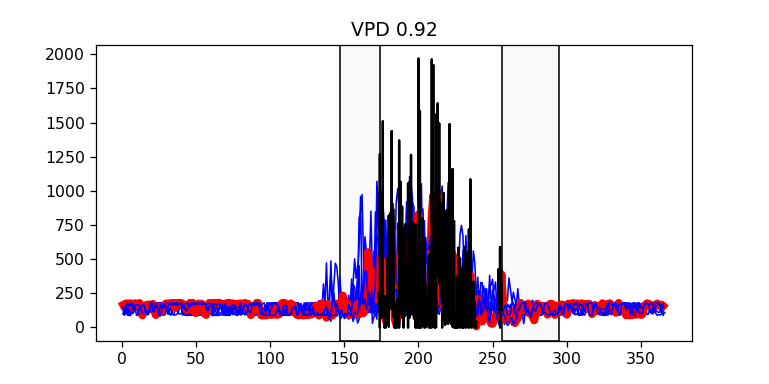

         RMSE     RMSES        R2       R2S
i                                          
4  104.457011  5.074687  0.921623  0.013935

r2:  0.9863968838571187
RMSE:  44.29040674787846


In [32]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
if len(Mods.keys())==1:
    ax = [ax]
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=False,min_samples_split=2)
    Data[Y+'_RF']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_RF']=Val
                     
    DNA = Data[y+[Y+'_RF']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_RF']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_RF'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

# Outputs

In [33]:
cols =['fch4','fco2','ch4_flux','co2_flux','Air_Temp','Rainfall','Wind_Speed','Wind_Direction',
        'Net_SW','Net_LW','Net_RN','Daytime','temperature_2m','dewpoint_temperature_2m',
       'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
#        'volumetric_soil_water_layer_3',
#        'volumetric_soil_water_layer_4',
       'soil_temperature_level_1','soil_temperature_level_2',
       'soil_temperature_level_3',#'soil_temperature_level_4',
       'DOY',
       'NDSI_FI_LCP','NDVI_FI_LCP',#'NDSI_fill','NDVI_fill',
       'GPP_FI_LCP','GPP_Ix',
       'snow_cover',
#        'NDSI_interp','GPP_interp','NDVI_interp',
       'Polygon','Rim','Polygon_Obs',
       'Rim_Obs',
       'VPD_RF',
       'Wind_Speed',
      'Net_RN',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       'VPD_RF',
       'PPFD_Avg_OLS',
       'u*_OLS',
       'Table_1_OLS',
       'AL_data_est',
       'Study_Season',
#        'Snow_Season','Green_Season','Warm',
#        'Freezing','Green','Snow',
#        'Ts_15_1_OLS','Ts_5_1_OLS,','Ts_15_2_OLS','Ts_5_2_OLS',#'VPD_OLS',
#        'PPFD_AWS_RF','u*_est_RF','WTD_RF','AL_data_est_RF',
       'NEE_FSO','NME_FSO','Season_Sum','Season_Root',#'Season_Sum2',
       'Season',#,'Season2','Season3',
      'Daytime',
      ]

RN = {'Wind_Speed':'wind_speed',
      'Net_RN':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
       'VPD_RF':'VPD',
       'PPFD_Avg_OLS':'PPFD_Avg',
       'u*_OLS':'u*',
       'Table_1_OLS':'Table_1',
       'AL_data_est':'Active_Layer_1',
     }


# 58.8%	25.6%

Data['Polygon_Obs'] = Data['Polygon'].copy()
# Data['Polygon']=Data['Polygon'].median()
Data['Polygon'] = 0.588 # ALF derrived values
Data['Rim_Obs'] = Data['Rim'].copy()
# Data['Rim']=Data['Rim'].median()
Data['Polygon'] = 0.256 # ALF derrived values


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

# Path = 'G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/'
    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
Export = Export.loc[((Export.index.month>=5)&(Export.index.month<=10))]
# Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Test.csv')
Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Final.csv')
# Export[cols].rename(columns=RN).to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AWS_FI_Test.csv')
print('Done')

Done


# WX Summary Stats


In [34]:
# print(AL.columns)
# print(AL[['Peak_Day','Peak_Height','Peak_NDVI']].corr()**2)
# print(AL[['Peak_Day_BL','Peak_Height_BL']].corr()**2)
# print(AL[['Peak_Height_BL','Peak_Height']].corr()**2)
# print()
# print(AL['Peak_NDVI'].median())
# # print(np.round(AL['Peak_Height'].max()-AL['Peak_Height'].min(),2))
# # print(np.round(AL['Peak_Height'].max()-AL['Peak_Height'].min(),2))

# print(AL['Start_Day'])
# AL['Peak_Date'] = pd.to_datetime(AL.index * 1000 + AL['Peak_Day'], format='%Y%j')
# AL['Peak_Date_BL'] = pd.to_datetime(AL.index * 1000 + AL['Peak_Day_BL'], format='%Y%j')
# AL['Start_Date'] = pd.to_datetime(AL.index * 1000 + AL['Start_Day'], format='%Y%j')
# AL['End_Date'] = pd.to_datetime(AL.index * 1000 + AL['End_Day'], format='%Y%j')
# Yrly = AL[['Peak_Height','Peak_Date','Peak_Date_BL','Peak_Height',]]#.sort_values(by='Season_Sum')
# print(Yrly)
# Yrly = AL[['Start_Date','End_Date','Season_Sum']].reset_index(drop=True)#.sort_values(by='Season_Sum').reset_
# print(Yrly)
# 

<IPython.core.display.Javascript object>


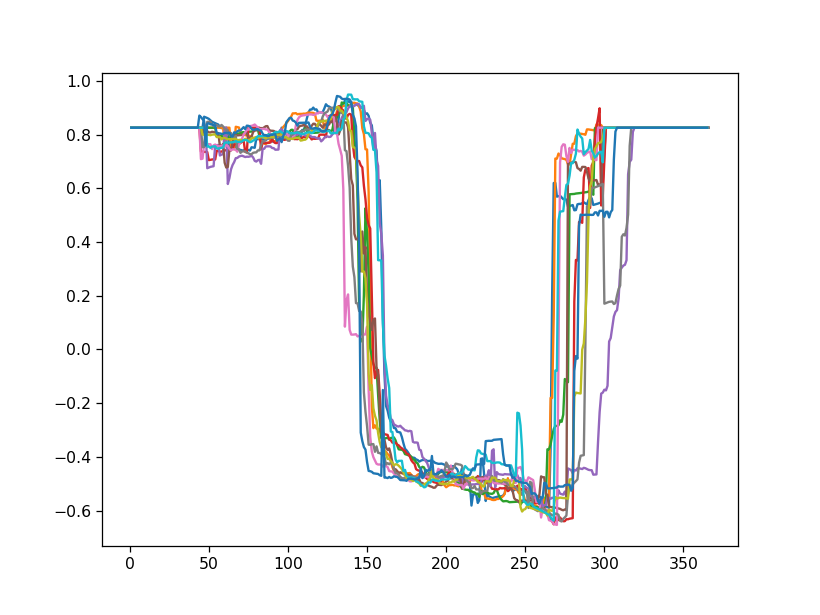

In [35]:
plt.figure()
for y in range(2009,2020):
    Y = Daily.loc[Daily.index.year==y]
    plt.plot(Y.index.dayofyear,Y['NDSI_fill'])

<IPython.core.display.Javascript object>


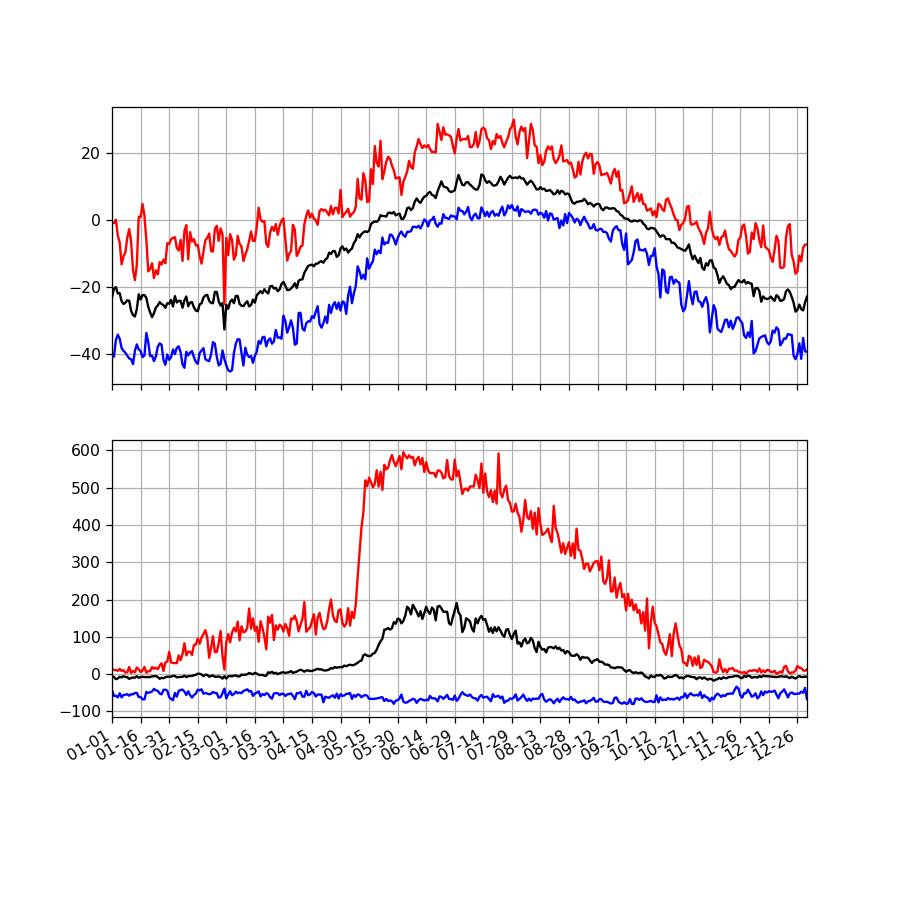

       DOY
MM-DD     
02-29   60


In [36]:
Data['MM-DD'] = Data.index.strftime('%m-%d')
Daily = Data.groupby('MM-DD').mean()
Dailymn = Data.groupby('MM-DD').min()
Dailymx = Data.groupby('MM-DD').max()
fig,ax = plt.subplots(2,sharex=True,figsize=(7,7))
from scipy import stats
# ax[0].errorbar(Daily.index,Daily['Air_Temp'],yerr=Dailys['Air_Temp'],color='r',ecolor='grey')
ax[0].plot(Daily.index,Daily['Air_Temp'],color='k')
ax[0].plot(Daily.index,Dailymn['Air_Temp'],color='b')
ax[0].plot(Daily.index,Dailymx['Air_Temp'],color='r')

# ax[0].plot(Daily.index,Daily['Air_Temp']+Dailys['Air_Temp']/(11**.5)*stats.t.ppf(1-0.025,11),color='r')#,ecolor='grey')
ax[0].grid()

ax[1].plot(Daily.index,Daily['Net_RN'],color='k')
ax[1].plot(Daily.index,Dailymn['Net_RN'],color='b')
ax[1].plot(Daily.index,Dailymx['Net_RN'],color='r')
ax[1].grid()

# Xt = ax[0].get_xticks()
# fig.canvas.draw()
# Xtl = ax[0].get_xticklabels()

P = np.arange(0,365,15)#[0,14,31,45,61,75,92,106,123,137,153,167,183]
# P = [0,14,31,45,61,75,92,106,123,137,153,167,183]
ax[-1].set_xticks(P)
ax[-1].set_xlim(0,365)
print(Dailymx.loc[Dailymx['Air_Temp']==Dailymx['Air_Temp'].min(),['DOY']])
# print(Dailymx)
fig.autofmt_xdate()

<IPython.core.display.Javascript object>


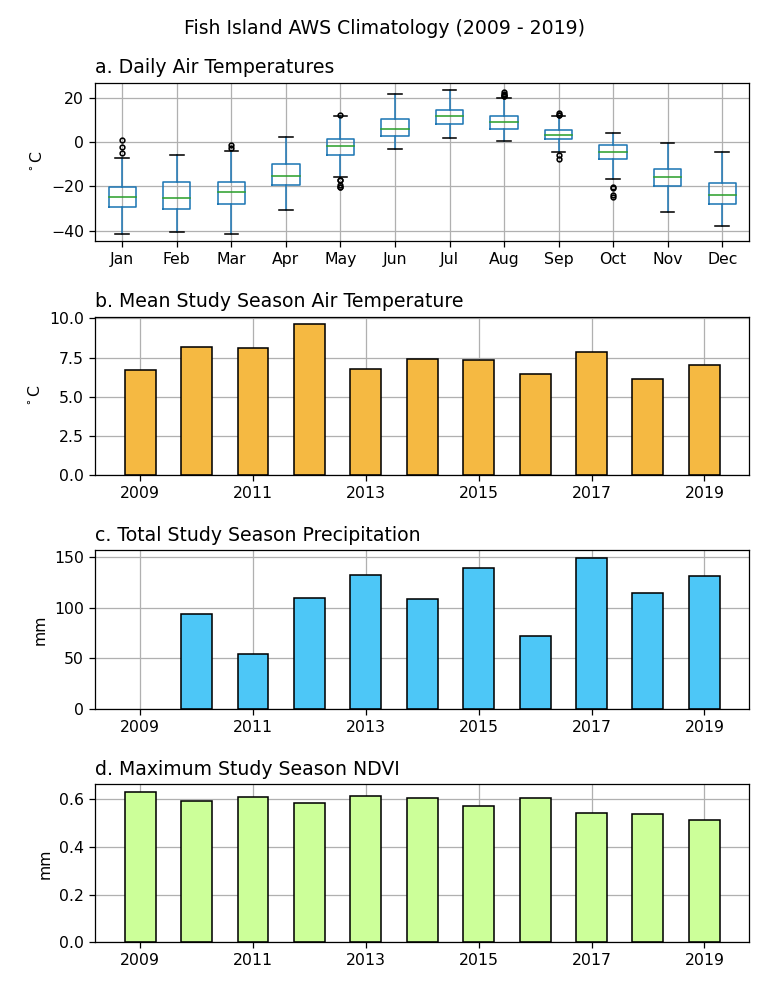

In [37]:
# Monthly = Data.groupby('Month')[['Air_Temp']]
# Monthly
# Data['Month']
plt.rcParams['axes.axisbelow'] = True

Daily = Data.resample('D').mean()


flierprops = dict(marker='o', markerfacecolor='None', markersize=3,
                  markeredgecolor='k'
                 )

fig,ax=plt.subplots(4,figsize=(6,7.75))


Daily.boxplot(column=['Air_Temp'],by=['Month'],ax=ax[0],flierprops=flierprops)
ax[0].set_xlabel('')
ax[0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax[0].set_ylabel('$^\circ$C')
ax[0].set_title('')
ax[0].set_title('a. Daily Air Temperatures',loc='left')



Annual = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009))].resample('Y').mean()#['Air_Temp']
Annualmx = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009))].resample('Y').max()#['Air_Temp']
Season = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                   (Data.Study_Season==1)
#                   (Data.index.month<=8)&(Data.index.month>=6)
                  )].resample('Y').mean()#['Air_Temp']
# print(Season)
Season = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                   (Data.Study_Season==1)
#                   (Data.index.month<=10)&(Data.index.month>=5)
                  )].resample('Y').mean()#['Air_Temp']

Season['NDVI'] = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                   (Data.Study_Season==1)
#                   (Data.index.month<=10)&(Data.index.month>=5)
                  )].resample('Y').max()['NDVI_FI_LCP']
SeasonS = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                    (Data.Study_Season==1)
#                   (Data.index.month<=10)&(Data.index.month>=5)
                   )].resample('Y').std()#['Air_Temp']

SeasonC = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                   (Data.Study_Season==1)
#                   (Data.index.month<=8)&(Data.index.month>=6)
                   )].resample('Y').count()#['Air_Temp']

Season['Rainfall'] = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                               (Data.Study_Season==1)
#                   (Data.index.month<=10)&(Data.index.month>=5)
                              )].resample('Y').sum()['Rainfall']
Season.loc[Season.index==Season.index[0],'Rainfall']=np.nan

# ax[1].plot(Annual.index,Annual['Air_Temp'])#,width=200)
ax[1].bar(Season.index,Season['Air_Temp'],
#           yerr=SeasonS['Air_Temp']/(SeasonC['Air_Temp']**.5)*stats.t.ppf(1-0.025,SeasonC['Air_Temp']),
                         width=200,edgecolor='k',color='#f5b942', capsize=5)
# ax[1].bar(Season.index,Season['Air_Temp'],width=200)
ax[1].set_title('b. Mean Study Season Air Temperature',loc='left')
ax[1].set_ylabel('$^\circ$C')
ax[1].grid()

ax[2].bar(Season.index,Season['Rainfall'],width=200,edgecolor='k',color='#4dc7f7')
ax[2].set_xlim(ax[1].get_xlim())
ax[2].set_title('c. Total Study Season Precipitation',loc='left')
ax[2].set_ylabel('mm')
ax[2].grid()


ax[3].bar(Season.index,Season['NDVI'],width=200,edgecolor='k',color='#ccff99')
ax[3].set_xlim(ax[1].get_xlim())
ax[3].set_title('d. Maximum Study Season NDVI',loc='left')
ax[3].set_ylabel('mm')
ax[3].grid()



Course = Daily.groupby(Daily.index.dayofyear).mean()

# ax[3].plot(Course['NDVI_FI_LCP'])

plt.suptitle('Fish Island AWS Climatology (2009 - 2019)')
plt.tight_layout()
plt.savefig(G_Drive+'PhD_Thesis/Chapter3_Figs/'+'Climatology.png')

In [38]:
# print(Daily.resample('Y').max()[['AL_data_est','Season_Root','Season_Sum']])
# Temp
# AL

# Data.loc[Data['Study_Season']==1].resample('Y').max()['AL_data_est']
# # Temp

Temp = FDF.copy()#loc[FDF.index>2008].copy()

Temp['Study_Start'] = (Data.loc[Data['Study_Season']==1].resample('Y').min()['Date'].values)
Temp['Study_End'] = (Data.loc[Data['Study_Season']==1].resample('Y').max()['Date'].values)
Temp['Study_Start']=pd.to_datetime(Temp['Study_Start']).dt.strftime('%b-%d')
Temp['Study_End']=pd.to_datetime(Temp['Study_End']).dt.strftime('%b-%d')
Temp['AL'] = (Data.loc[Data['Study_Season']==1].resample('Y').max()['AL_data_est'].round(3).values)
Temp['S'] = (Data.loc[Data['Study_Season']==1].resample('Y').max()['Season_Sum'].values)
# AL[AL_s]
# AL[AL_s]
# Temp[[]]
# Temp

Temp['Study_Start_doy'] = (Data.loc[Data['Study_Season']==1].resample('Y').min()['DOY'].values)
Temp['Study_End_doy'] = (Data.loc[Data['Study_Season']==1].resample('Y').max()['DOY'].values)
# # # Data['Season_Root']

Temp['Duration']=Temp['Study_End_doy']-Temp['Study_Start_doy']
Temp[['Study_Start','Study_End','AL','Duration']]
# Temp['Study_Start_doy'].max()-Temp['Study_Start_doy'].min()
# Temp['Study_End_doy'].max()-Temp['Study_End_doy'].min()

# # Data.loc[Data['Study_Season']==1].resample('Y').min()['Date'].values
# Temp

# print(Data.loc[Data.index.year==2013,['AL_data_est','snow_cover']].dropna())

,Study_Start,Study_End,AL,Duration
2008,May-25,Sep-21,NaN,119
2009,May-29,Sep-23,0.511,117
2010,May-20,Sep-26,0.528,129
2011,May-23,Oct-01,0.539,131
2012,May-22,Oct-09,0.563,140
2013,May-30,Oct-24,0.572,147
2014,May-27,Sep-28,0.531,124
2015,May-14,Sep-28,0.550,137
2016,May-10,Oct-14,0.578,157
2017,May-19,Oct-08,0.561,142


<IPython.core.display.Javascript object>


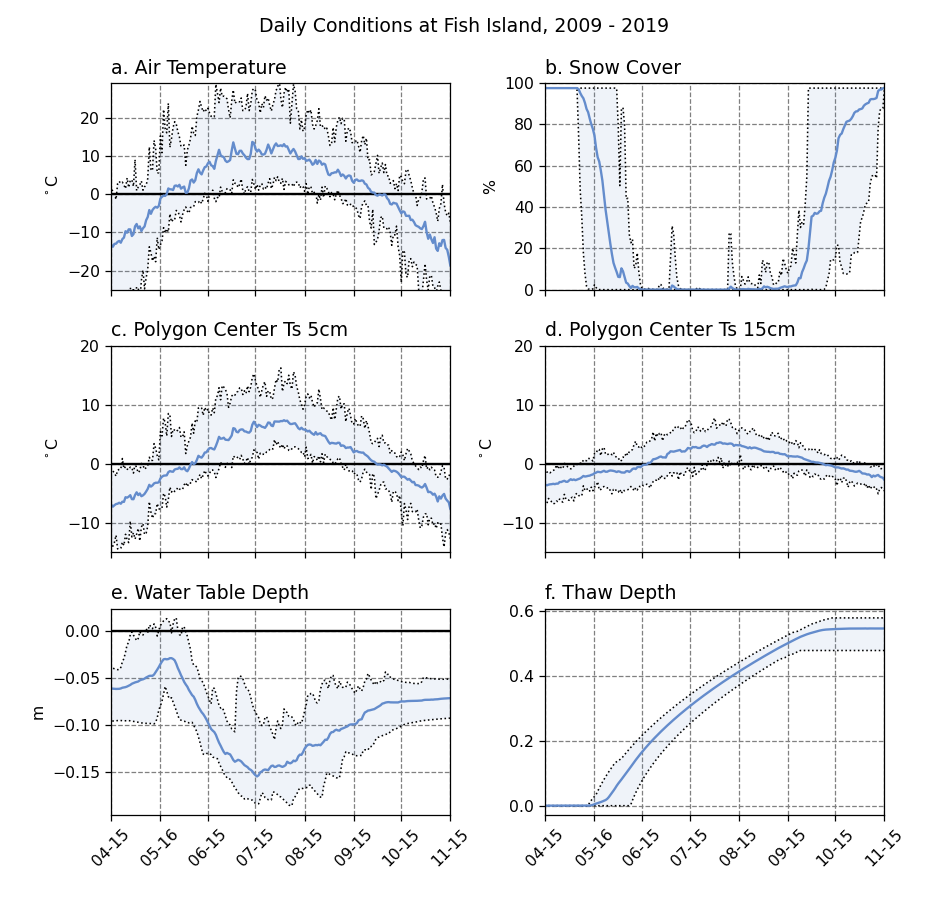

In [39]:
# print((Data_y[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])
Data['MM-DD'] = Data.index.strftime('%m-%d')
DataT = Data.loc[((Data.index.month>=4)&(Data.index.month<=11))]

Data_d = DataT.groupby('MM-DD').mean()
Data_d_mx = DataT.groupby('MM-DD').max()
Data_d_mn = DataT.groupby('MM-DD').min()
# print((Data_d[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])

fig,axes = plt.subplots(3,2,figsize=(7.25,7),sharex=True)#(18.2*cm_2_in, 13*cm_2_in),sharex=True)

ecolor='k'
ax = axes[0,0]
ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
ax.plot(Data_d['Air_Temp'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Air_Temp'],Data_d_mx['Air_Temp'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('a. Air Temperature',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-25,29)

ax = axes[0,1]
# ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
ax.plot(Data_d['snow_cover'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['snow_cover'],Data_d_mx['snow_cover'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('b. Snow Cover',loc='left')
ax.set_ylabel('%')
ax.set_ylim(0,100)


ax = axes[1,0]
ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
ax.plot(Data_d['Temp_5_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Temp_5_1_OLS'],Data_d_mx['Temp_5_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('c. Polygon Center Ts 5cm',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-15,20)

ax = axes[1,1]
ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
ax.plot(Data_d['Temp_15_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Temp_15_1_OLS'],Data_d_mx['Temp_15_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('d. Polygon Center Ts 15cm',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-15,20)




ax = axes[2,0]
ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
ax.plot(Data_d['Table_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Table_1_OLS'],Data_d_mx['Table_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('e. Water Table Depth',loc='left')
ax.set_ylabel('m')

for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(45)


D_d = DataT.resample('D').mean()
D_d['MM-DD'] = DataT.resample('D').first()['MM-DD']

ax = axes[2,1]


ax.plot(Data_d['AL_data_est'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['AL_data_est'],Data_d_mx['AL_data_est'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')



# for y in range(2009,2020):

# # ax.plot(Data_d['Temp_5_1_OLS']*0,color='k')
#     ax.plot(D_d.loc[((D_d.index.year==y)&(D_d.AL_data_est>0)),'MM-DD'],
#             D_d.loc[((D_d.index.year==y)&(D_d.AL_data_est>0)),'AL_data_est'],color='#648ccc')
# ax.fill_between(Data_d.index,Data_d_mn['AL_data_est'],Data_d_mx['AL_data_est'],
#                 facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('f. Thaw Depth',loc='left')

for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(45)
    
    


P = [0,14,30,45,61,75,92,105,123,136,153,167,183,197,210,228]
# # # P = [0,14,31,45,61,75,92,106,123,137,153,167,183]
ax.set_xticks(P[1::2])
ax.set_xlim(14,228)

plt.suptitle('Daily Conditions at Fish Island, 2009 - 2019')

plt.tight_layout()

# plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_FiData/Drivers_OLS.jpg',dpi=600)
plt.savefig(G_Drive+'PhD_Thesis/Chapter3_Figs/'+'DailyValues.png')

<IPython.core.display.Javascript object>


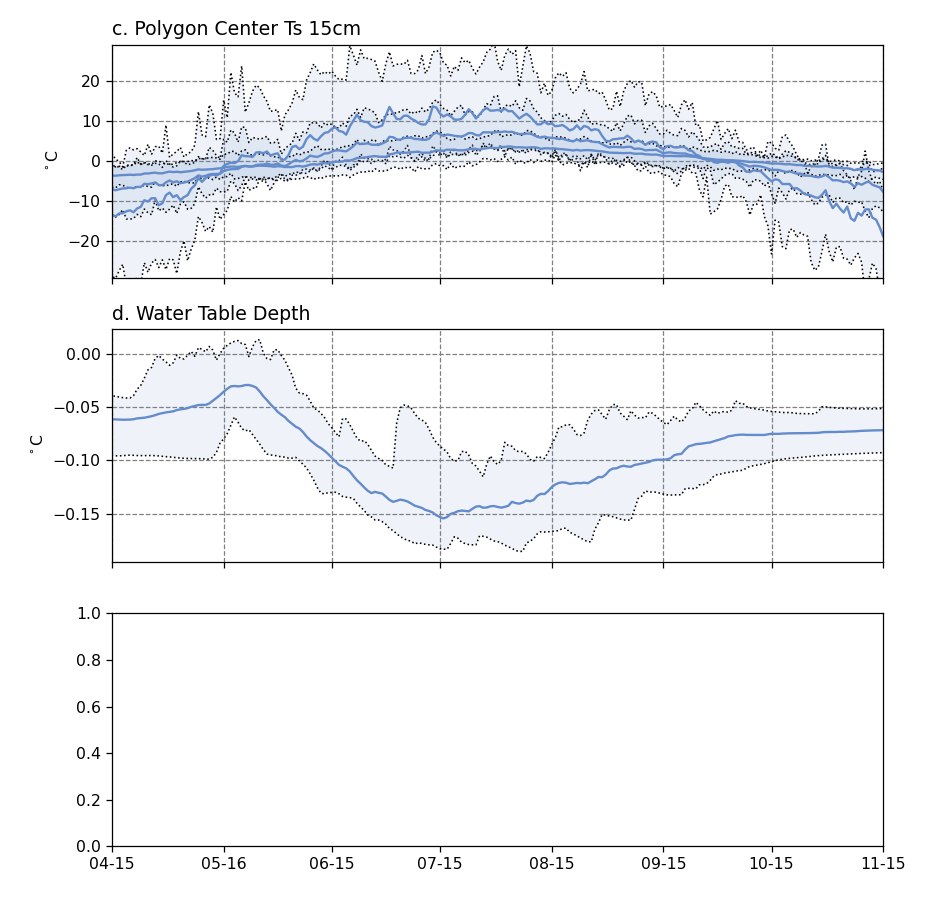

In [40]:
# print((Data_y[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])
Data['MM-DD'] = Data.index.strftime('%m-%d')
DataT = Data.loc[((Data.index.month>=4)&(Data.index.month<=11))]

Data_d = DataT.groupby('MM-DD').mean()
Data_d_mx = DataT.groupby('MM-DD').max()
Data_d_mn = DataT.groupby('MM-DD').min()
# print((Data_d[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])

fig,axes = plt.subplots(3,figsize=(7.25,7),sharex=True)#(18.2*cm_2_in, 13*cm_2_in),sharex=True)

ecolor='k'
ax = axes[0]
ax.plot(Data_d['Air_Temp'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Air_Temp'],Data_d_mx['Air_Temp'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('a. Air Temperature',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-29,29)


# ax = axes[0,1]
ax.plot(Data_d['Temp_5_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Temp_5_1_OLS'],Data_d_mx['Temp_5_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('b. Polygon Center Ts 5cm',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-29,29)

# ax = axes[1,0]
ax.plot(Data_d['Temp_15_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Temp_15_1_OLS'],Data_d_mx['Temp_15_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('c. Polygon Center Ts 15cm',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-29,29)

ax = axes[1]
ax.plot(Data_d['Table_1_OLS'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Table_1_OLS'],Data_d_mx['Table_1_OLS'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('d. Water Table Depth',loc='left')
ax.set_ylabel('$^\circ$C')

# ax = axes[2,0]
# ax.plot(Data_d['snow_cover'],color='#648ccc')
# ax.fill_between(Data_d.index,Data_d_mn['snow_cover'],Data_d_mx['snow_cover'],
#                 facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
# ax.set_axisbelow(True)
# ax.grid(color='gray', linestyle='dashed')
# ax.set_title('e. Snow Cover',loc='left')
# ax.set_ylabel('%')
for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(45)

    
    
# ax = axes[2,1]
# ax.plot(Data_d['NDVI_FI_LCP'],color='#648ccc')
# ax.fill_between(Data_d.index,Data_d_mn['NDVI_FI_LCP'],Data_d_mx['NDVI_FI_LCP'],
#                 facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
# ax.set_axisbelow(True)
# ax.grid(color='gray', linestyle='dashed')
# ax.set_title('f. NDVI',loc='left')

for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(45)
    
    


P = [0,14,30,45,61,75,92,105,123,136,153,167,183,197,210,228]
# # # P = [0,14,31,45,61,75,92,106,123,137,153,167,183]
ax.set_xticks(P[1::2])
ax.set_xlim(14,228)


plt.tight_layout()

# plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_FiData/Drivers_OLS.jpg',dpi=600)
plt.savefig(G_Drive+'PhD_Thesis/Chapter3_Figs/'+'DailyValues.png')

<IPython.core.display.Javascript object>


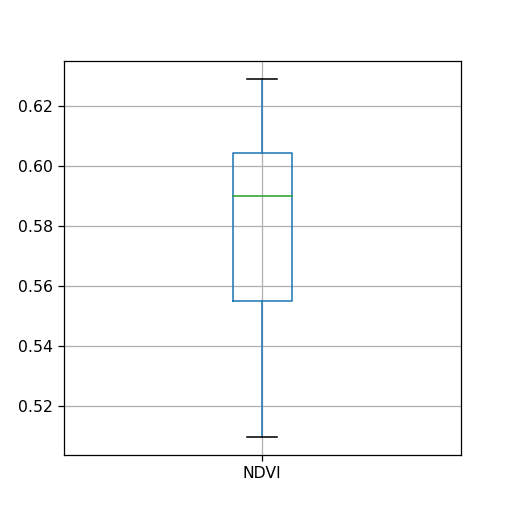

(-0.009581963105561793, 19.888022752871823, -0.01521436753761804, -0.0028316366188014253)
LinregressResult(slope=-0.00910261586156199, intercept=18.912887669212868, rvalue=-0.8220105875777598, pvalue=0.0019040408836236888, stderr=0.0021020356742418316, intercept_stderr=4.233505066479103)


In [41]:

# Annualmx = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009))].resample('Y').max()#['Air_Temp']
# Summer = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
#                    (Data.index.month>=6&(Data.index.month<=9))
# #                   (Data.index.month<=8)&(Data.index.month>=6)
#                   )].resample('Y').mean()#['Air_Temp']
v='NDVI'
plt.figure(figsize=(4,4))
Season.boxplot(column=v)
# plt.bar(Summer['Net_SW'].resample('Y').mean().index,Summer['Wind_Speed'].resample('Y').mean(),width=200)
Season[v].sort_values()
Season['Y'] = Season.index.year
Season[['NDVI','Y']].corr()
Mod = LinearRegression()#fit_intercept=fit_intercept)
Mod.fit(Season[['Y']],Season['NDVI'])
Mod.score(Season[['Y']],Season['NDVI'])

from scipy import stats

y = Season['NDVI'].values
x = Season['Y'].values

res = stats.theilslopes(y, x, 0.95)
print(res)
lsq_res = stats.linregress(x, y)
print(lsq_res)

# Val = Model_Test(['Y'],['NDVI'],Season[['NDVI','Y']],
#                             K=2,Test = 'OLS',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)


In [42]:
D = Data.loc[((Data.index.year<=2019)&(Data.index.year>=2009)&
                   (Data.Study_Season==1)#&(Data.Wind_Speed>=10)
                  ),'Wind_Speed'].resample('D').max()
D.resample('Y').max()#['Wind_Speed']
D.loc[D>10].resample('Y').count()

2010-12-31 00:00:00-07:00    2
2011-12-31 00:00:00-07:00    0
2012-12-31 00:00:00-07:00    5
2013-12-31 00:00:00-07:00    3
2014-12-31 00:00:00-07:00    4
2015-12-31 00:00:00-07:00    3
2016-12-31 00:00:00-07:00    2
2017-12-31 00:00:00-07:00    4
2018-12-31 00:00:00-07:00    2
2019-12-31 00:00:00-07:00    4
Freq: A-DEC, Name: Wind_Speed, dtype: int64